# Simulate genotype likelihoods (GL) from tree sequence data

In this jupyternotebook I'll create a series of python functions in order to simulate GL from tree structure data or the genotype matrix derived from it by using `tskit` package. For that, I'm based on Graham Gower's gist and `angsd`'s `msToGlf` program. 

Graham's gist:

https://gist.github.com/grahamgower/10779172a4a8368f993e154bf69dbe33

# 0. Importing packages for python and R

In [1]:
import time
import numpy as np
import pandas as pd 
import msprime
import tskit
import simGL
import matplotlib.pyplot as plt 

%load_ext rpy2.ipython

#from rpy2.robjects import r, pandas23ri
#pandas2ri.activate()

In [2]:
%%R

#.libPaths(c("/maps/projects/racimolab/people/qxz396/simGL/notebook/renv/library/R-4.1/x86_64-redhat-linux-gnu", "/tmp/Rtmp9Hi1cZ/renv-system-library"))

library(ggplot2)
library(tidyverse)
library(cowplot)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# 1. Simulate a haplotype matrix

From Graham's code, I use a function of his to simulate a tree

In [4]:
def sim(seeds=(1, 2), n = 5):
    ts = msprime.sim_ancestry(
        population_size=10_000,
        samples=n,
        sequence_length=100_000,
        recombination_rate=1.25e-8,
        random_seed=seeds[0],
        record_provenance=False,
    )
    ts = msprime.sim_mutations(ts, rate=1.25e-8, random_seed=seeds[1])
    return ts

ts = sim(seeds=(1, 2))
ts

Comments:

1. Why is it necessary to give different seeds?

From that, I extract the positions (reusing Graham's code):

In [4]:
pos = np.array(ts.tables.sites.position)
print(pos.shape)
pos

(115,)


array([  233.,   295.,  1688.,  2205.,  2515.,  2795.,  3357.,  4219.,
        4272.,  4337.,  4691.,  4824.,  5616.,  6598.,  6633.,  6886.,
        7378.,  7504.,  9248.,  9611., 10458., 11168., 11563., 12840.,
       13258., 13476., 14359., 14469., 15237., 15606., 15713., 16003.,
       16835., 17014., 17717., 18287., 18893., 19484., 25020., 25396.,
       26548., 27485., 27544., 27797., 30140., 30240., 32132., 32434.,
       32511., 32597., 32703., 32836., 32904., 32990., 34452., 35289.,
       36367., 36682., 37246., 39165., 39567., 41466., 42729., 43633.,
       43919., 45359., 45754., 46347., 49205., 49306., 49511., 49675.,
       50698., 50728., 54036., 54442., 55979., 56654., 56876., 56993.,
       57373., 60741., 60827., 61060., 61178., 64234., 67527., 67790.,
       70380., 73119., 73319., 74320., 74773., 74871., 74921., 78772.,
       79457., 79968., 81191., 82526., 82548., 83269., 83744., 84376.,
       84650., 86147., 86182., 89241., 90613., 92725., 92941., 93545.,
      

and extracting the haplotype allele counts (0 = anc allele, 1 = der allele)

In [5]:
M = ts.genotype_matrix()
print(M.shape)
M

(115, 10)


array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

> ### Comments:
1. I change dimensions from Graham's original code and make rows (first dimension) to correspond to SNPs and columns (second dimension) to correspond to haplotypes.

# 2. Simulate GL

To simulate the GL from haplotypic allele counts, I'm going to use a similar approach than ANGSD `msToGlf` using the GL model from GATK (as shown in the picture abovell:

1. sample the mean **coverage per haplotype** (assuming that coverage is **distributed normally** among individuals with a std = 0.05\*mean  from the mean) 
2. sample **coverage per site per haplotype** (assuming **poison distribution** with lambda equal to the haplotype coverage)
3. sample as many **alleles reads** as depth per site per haplotype from a **multinomial distribution** with probabilities (1-e, e/3, e/3, e/3), assuming that the first position in the array corresponds to calling the correctly the allele and the rest correspond to calling an error.
4. assuming that index 0 = A = anc, index 1 = C = der, index 2 = G, index 3 = T, I'll **organize the allele read counts** in each array drawn from the multinomial distribution to correspond to the simulated allele counts per haplotype. Then, I'll **join every two haplotypes** to get the allele read counts per diploid individual.
5. **Compute GLs**


![Gl](GL.png)

source: 
1. http://www.popgen.dk/angsd/index.php/Genotype_Likelihoods
2. https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/1471-2105-14-289.pdf

## 2.1. Coverage per haplotype

In [6]:
rng = np.random.default_rng(1234) #Why setting the seed like this?
mean_depth = 30
#mean_depths = rng.exponential(mean_depth, size=A.shape[1]) #Why exponential?
mean_depths = rng.normal(loc = mean_depth/2, scale = 0.05*mean_depth, size=M.shape[1])
print(mean_depths.shape)
mean_depths

(10,)


array([12.59424479, 15.09614987, 16.11133694, 15.22892879, 16.29561584,
       19.36964883, 12.78176496, 16.41820946, 12.50079681, 15.51561687])

> ### Comments:
1. Why is the coverage per individual sampled from an exponential distribution? I usually observe this to be normally distributed. I would be also nice to be able to define beforehand the coverage per sample.
2. Why setting the coverage like that?

## 2.2. Coverage per SNP per haplotype

In [7]:
DP = rng.poisson(mean_depths, size=M.shape)
print(DP.shape)
DP[:10, :]

(115, 10)


array([[12, 17, 19, 11, 18, 18, 17, 10, 16, 20],
       [11,  9, 16, 15, 25, 19, 10, 18, 12, 12],
       [11, 13, 21,  9, 18, 30, 16, 14, 18,  8],
       [12, 13, 25, 13, 14, 19, 15, 18,  9, 14],
       [15, 17, 17,  6, 19, 22, 18, 10,  8, 15],
       [ 6, 15, 13, 21, 24, 10,  8, 23, 10, 15],
       [13, 26, 19, 15, 21, 12, 13, 16, 14, 12],
       [ 9, 23, 19,  7, 17, 22, 16, 13, 18, 18],
       [11, 20, 14,  6, 14, 16, 14, 21,  8, 15],
       [11, 15, 17, 15,  7, 18, 13, 18, 16, 12]])

> ### Comments:

1. I don't think reshaping is necessary

## 2.3. Sampling allele reads for each haplotype and site with and without errors

Base pairs are coded in the following way:

1. 0 = correctly called allele
2. 1 = 2 = 3 = error called

If we check the coverage per site per haplotype...

In [8]:
print(DP.shape)
DP

(115, 10)


array([[12, 17, 19, ..., 10, 16, 20],
       [11,  9, 16, ..., 18, 12, 12],
       [11, 13, 21, ..., 14, 18,  8],
       ...,
       [10, 19, 17, ..., 12, 14,  9],
       [15, 13, 18, ..., 19, 10, 20],
       [11, 11, 14, ..., 20, 11, 21]])

This means that for the first haplotype and first position there should be 12 alleles sampled in total. I'll do that by sampling from a multinomial distribution with probabilities (1-e, e/3, e/3, e/3).

In [9]:
e = 0.05
reads_per_haplotype = np.array([rng.multinomial(dp, [1-e, e/3, e/3, e/3]).tolist() for dp in DP.reshape(-1)]).reshape(DP.shape[0], DP.shape[1], 4)
print(reads_per_haplotype.shape)
reads_per_haplotype

(115, 10, 4)


array([[[12,  0,  0,  0],
        [17,  0,  0,  0],
        [18,  1,  0,  0],
        ...,
        [10,  0,  0,  0],
        [15,  1,  0,  0],
        [19,  1,  0,  0]],

       [[11,  0,  0,  0],
        [ 9,  0,  0,  0],
        [15,  0,  1,  0],
        ...,
        [16,  0,  1,  1],
        [11,  1,  0,  0],
        [12,  0,  0,  0]],

       [[ 9,  1,  1,  0],
        [11,  1,  1,  0],
        [20,  1,  0,  0],
        ...,
        [13,  1,  0,  0],
        [18,  0,  0,  0],
        [ 8,  0,  0,  0]],

       ...,

       [[ 9,  0,  0,  1],
        [18,  1,  0,  0],
        [17,  0,  0,  0],
        ...,
        [12,  0,  0,  0],
        [14,  0,  0,  0],
        [ 9,  0,  0,  0]],

       [[14,  0,  0,  1],
        [11,  0,  2,  0],
        [17,  0,  1,  0],
        ...,
        [19,  0,  0,  0],
        [ 9,  1,  0,  0],
        [20,  0,  0,  0]],

       [[10,  1,  0,  0],
        [10,  0,  0,  1],
        [14,  0,  0,  0],
        ...,
        [18,  0,  0,  2],
        [10,  0

We can see that the first line summed up is the same as the first position in the depth array (DP) shown before. Rows that have counts in places other than the first position, correspond to errors. 

## 2.4. Organizing allele reads for each haplotype corresponding to the allele counts simulated

In this section I'll change the counts of the first and second positions of every array depending on the allele counts `M` depending on a given individual and site having the derived or ancestral allele such that in a given array:

1. index 0 = A = ancestral allele
2. index 1 = C = derived allele
3. index 2 = G
4. index 3 = T

So, if we check the M matrix:

In [10]:
M

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

We can see that the first haplotype has a derived allele in the first SNP. Thus, we must swap the allele read counts between the first and second position of the first array in `reads_per_haplotype`.

In [11]:
reads_per_haplotype_copy = np.copy(reads_per_haplotype)
reads_per_haplotype[M == 1, 1] = reads_per_haplotype_copy[M == 1, 0]
reads_per_haplotype[M == 1, 0] = reads_per_haplotype_copy[M == 1, 1]
print(reads_per_haplotype.shape)
reads_per_haplotype

(115, 10, 4)


array([[[ 0, 12,  0,  0],
        [ 0, 17,  0,  0],
        [ 1, 18,  0,  0],
        ...,
        [ 0, 10,  0,  0],
        [ 1, 15,  0,  0],
        [ 1, 19,  0,  0]],

       [[11,  0,  0,  0],
        [ 9,  0,  0,  0],
        [15,  0,  1,  0],
        ...,
        [16,  0,  1,  1],
        [11,  1,  0,  0],
        [12,  0,  0,  0]],

       [[ 9,  1,  1,  0],
        [ 1, 11,  1,  0],
        [20,  1,  0,  0],
        ...,
        [ 1, 13,  0,  0],
        [18,  0,  0,  0],
        [ 8,  0,  0,  0]],

       ...,

       [[ 9,  0,  0,  1],
        [ 1, 18,  0,  0],
        [17,  0,  0,  0],
        ...,
        [ 0, 12,  0,  0],
        [14,  0,  0,  0],
        [ 9,  0,  0,  0]],

       [[14,  0,  0,  1],
        [11,  0,  2,  0],
        [17,  0,  1,  0],
        ...,
        [19,  0,  0,  0],
        [ 9,  1,  0,  0],
        [ 0, 20,  0,  0]],

       [[10,  1,  0,  0],
        [10,  0,  0,  1],
        [14,  0,  0,  0],
        ...,
        [18,  0,  0,  2],
        [10,  0

We can see that with this operation, the allele counts for the first and second position of SNPs for which haplotypes have the derived allele called have been swapped. 

> ### Comments:

1. There might be a better way to do this operation with numpy...

Finally, I can merge every two haplotypes to simulate diploid individuals. So, instead of having 10 haplotypes, I'll have only 5 individuals with the information corresponding to the allele read counts for every site. 

In [12]:
reads_per_genotype = reads_per_haplotype.reshape(reads_per_haplotype.shape[0], reads_per_haplotype.shape[1]//2, 2, reads_per_haplotype.shape[2]).sum(axis = 2)
print(reads_per_genotype.shape)
reads_per_genotype

(115, 5, 4)


array([[[ 0, 29,  0,  0],
        [ 1, 29,  0,  0],
        [18, 18,  0,  0],
        [ 0, 27,  0,  0],
        [ 2, 34,  0,  0]],

       [[20,  0,  0,  0],
        [30,  0,  1,  0],
        [23, 20,  1,  0],
        [25,  0,  2,  1],
        [23,  1,  0,  0]],

       [[10, 12,  2,  0],
        [20, 10,  0,  0],
        [17, 27,  1,  3],
        [16, 13,  1,  0],
        [26,  0,  0,  0]],

       ...,

       [[10, 18,  0,  1],
        [25,  2,  0,  0],
        [ 0, 37,  1,  1],
        [14, 12,  0,  0],
        [23,  0,  0,  0]],

       [[25,  0,  2,  1],
        [33,  0,  1,  0],
        [35,  1,  0,  0],
        [19, 15,  1,  0],
        [ 9, 21,  0,  0]],

       [[20,  1,  0,  1],
        [14, 10,  0,  0],
        [38,  0,  1,  0],
        [29,  0,  1,  2],
        [31,  0,  0,  1]]])

## 2.5. Compute GLs

In [13]:
#AA, AC, AG, AT, CC, CG, CT, GG, GT, TT
#00, 01, 02, 03, 11, 12, 13, 22, 23, 33
GL = []
for i in range(4):
    for j in range(i, 4):
        if i == j:
            GL.append(-np.log(np.power(((1-e)/2 + (1-e)/2), reads_per_genotype[:, :, i]) * 
                             np.power(((e/3)/2 + (e/3)/2), reads_per_genotype.sum(axis = 2)-reads_per_genotype[:, :, i])))
        else:
            
            GL.append(-np.log(np.power(((1-e)/2 + (e/3)/2), reads_per_genotype[:, :, i]+reads_per_genotype[:, :, j]) * 
                             np.power(((e/3)/2 + (e/3)/2), reads_per_genotype.sum(axis = 2)-reads_per_genotype[:, :, i]-reads_per_genotype[:, :, j])))

GL = np.array(GL)
GL = GL - GL.min(axis = 0)
print(GL.shape)
GL

(10, 115, 5)


array([[[117.24848677, 113.2054355 ,  48.44772706, 109.16238423,
         129.37764057],
        [  0.        ,   0.        ,  51.80354153,   0.        ,
           0.        ],
        [ 33.64999558,  20.15784954,  79.42914497,  32.96275878,
           0.        ],
        ...,
        [ 53.85377056,   0.        , 149.59289691,  30.94697383,
           0.        ],
        [  0.        ,   0.        ,   0.        ,  37.67008413,
          64.63141349],
        [  0.        ,  24.21238217,   0.        ,   0.        ,
           0.        ]],

       [[ 19.5969077 ,  16.22961187,   0.        ,  18.24539682,
          16.24109323],
        [ 13.51510876,  20.27266314,   0.        ,  16.89388595,
          12.17507924],
        [  0.        ,   0.        ,   0.        ,   0.        ,
          17.56964138],
        ...,
        [  0.        ,  10.15929429,  25.0029512 ,   0.        ,
          15.54237507],
        [ 16.89388595,  22.29992945,  20.28414449,   0.        ,
           0.    

## 3. All together and running time tests

Here I just put all the steps together in a single function and run it for different simulated datasets with varying number of individuals to test how fast the function is. 

In [209]:
def samples_order(ts):
    so = []
    for ind in ts.individuals():
        [so.append(nod) for nod in ind.nodes]
    return np.array(so)

def extract_genotype_matrix(data):
    if type(data) == np.ndarray and len(data.shape) == 2:
        return data
    elif type(data) == tskit.trees.TreeSequence:
        return data.genotype_matrix()[:, samples_order(data)]
    else:
        sys.exit("Incorrect data format")

def incorporate_monomorphic(poly_gm, pos, start, end):
    '''
    Def:
        Function to incorporate monomorphic sites in a polymorphic genotype matrix. 
    Input:
        - poly_gm : numpy array genotype matrix with size (SNPs, haplotypic samples) in which 0 denotes ancestral or reference allele
                    and 1 denotes derived or alternative allele.
        - pos     : numpy array with size (SNPs, ) with the discrete numeric coordinate position (int or float) of the polymorphisms
                    in poly_gm and with the same order.
        - start   : int >= 0 <= min(pos) that denote the start coordinate of the region simulated.
        - end     : int >= max(pos) that denote the end coordinate of the region simulated.
    '''
    if not (isinstance(start, (int, float)) and start >= 0 and start <= min(pos)):
        raise TypeError('Incorrect "start" format: it has to be an integer value >=0 and <= min(pos) ') 
    if not (isinstance(end, (int, float)) and end >= max(pos)):
        raise TypeError('Incorrect "end" format: it has to be an integer value >= max(pos)') 
    if not (isinstance(poly_gm, np.ndarray) and len(poly_gm.shape) == 2 and ((poly_gm == 0)+(poly_gm == 1)).sum() == poly_gm.size):
        raise TypeError('Incorrect "poly_gm" format: it has to be a numpy array with dimentions (SNP, haplotypic samples) with integer values 1 and 0')  
    if not (isinstance(pos, np.ndarray) and len(pos.shape) == 1):
        raise TypeError('Incorrect "pos" format: it has to be a numpy array with dimentions (SNP, ) ')
    if not (pos.shape[0] == poly_gm.shape[0]):
        raise TypeError('Incorrect "poly_gm" and/or "pos" format: They must have the same first dimention poly_gm.shape = (x, y) and  pos.shape = (x, )')
    gm = np.zeros((int(end)-int(start), poly_gm.shape[1]))
    gm[pos.astype(int)] = poly_gm
    return gm
        
def depth_per_haplotype(rng, mean_depth, std_depth, n_hap, ploidy):
    if isinstance(mean_depth, (int, float)) and mean_depth > 0.0:
        if isinstance(std_depth, (int, float)) and std_depth >= 0.0:
            DPh = []
            while len(DPh) < n_hap:
                dp = rng.normal(loc = mean_depth/ploidy, scale = std_depth, size=1)[0]
                if dp > 0:
                    DPh.append(dp)
            return DPh
        else:
            raise TypeError('Incorrect "std_depth" format: it has to be a single numeric value (float or int) and >=0 ') 
    elif isinstance(mean_depth, np.ndarray) and len(mean_depth.shape) == 1 and mean_depth.shape[0] == n_hap and (mean_depth > 0).sum() == n_hap:
        return mean_depth
    else:
        raise TypeError('Incorrect "mean_depth" format: it has to be either a single numeric value (float or int) and >0 or a single-dimention numpy array with length equal to the number of haplotipic samples of the genotype matrix and with all values > 0')
        

def refalt_int_encoding(gm, ref, alt):
    refalt_str                    = np.array([ref, alt])
    refalt_int                    = np.zeros(refalt_str.shape, dtype=int)
    refalt_int[refalt_str == "C"] = 1
    refalt_int[refalt_str == "G"] = 2
    refalt_int[refalt_str == "T"] = 3
    return refalt_int[gm.reshape(-1), np.repeat(np.arange(gm.shape[0]), gm.shape[1])].reshape(gm.shape)

        
def sim_allelereadcounts(gm, ref = "", alt = "", mean_depth = 30., std_depth = 5., e = 0.05, ploidy = 2, seed = 1234):
    '''
    Def:
        Function to simulate read counts for alleles given a tree sequence data from diploid simulated individuals (2samples = ind) 
        or genotype matrix and extra information for the haplotype samples.
    Input:
        - gm         : Genotype matrix in numpy format with shape (SNPs, samples). It is assumed that the array is sorted
                       according to a individual order such that consecutive columns (e.g., gm[:, 0] and gm[:, 1]) 
                       correspond to the same individual.
        - mean_depth : Two inputs are possible:
                            + float > 0 with the mean depth per sample. The mean depth for every sample haplotype 
                              is going to be sampled from a normal distribution with mean = mean_depth and std = std_depth.
                              Consider that since this script assumes that individuals are diploid, if the user intends to 
                              simulate a coverage of 30X per individual, the argument should be set to 15.
                            + numpy array with shape (samples, ) with the mean depth per haplotype sample. All values must 
                              be > 0. The order of the values is going to be associated to the list of individual's samples
                              provided by ts.individuals() (in case a tree sequence data is provided) or the order of the
                              samples in the genotype matrix (if a genotype matrix is provided in the input data).
                              If the intended coverage per site for a given individual is 30, since the coverage is 
                              given per haplotype, it should be indicated consecutively and half the individual coverage (15 
                              and 15 or 14 and 16).
        - std_depth  : float that corresponds to the standard deviation of the normal distribution from which coverages are
                       going to be sampled. This value will only be used if a float value is inputet for mean_depth. 
        - e          : float between 0 and 1 representing the error rate per base per read per site. This probability is
                       assumed to be constant.
        - ploidy     : int with the number of haplotypic sequences per individual
        - seed       : integer from which the numpy rng will be drawn. 
    Output:
        - Rg         : numpy array with dimentions (SNP, individual, alleles) so that each value corresponds to the number of
                       reads with a particular allele for a SNP position and a diploid individual. The index of the 3rd dimention
                       corresponds to 1 : A and ancestral allele, 2 : C and derived allele, 3 : G, 4: T. 
    '''
    #Checks
    if not (isinstance(gm, np.ndarray) and len(gm.shape) == 2 and ((gm == 0)+(gm == 1)).sum() == gm.size):
        raise TypeError('Incorrect "gm" format: it has to be a numpy array with dimentions (SNP, haplotypic samples) with integer values 1 and 0')
    if isinstance(ref, str) and isinstance(alt, str) and ref == "" and alt == "":
        ref = np.full(gm.shape[0], "A")
        alt = np.full(gm.shape[0], "C")
    elif not (isinstance(ref, np.ndarray) and isinstance(alt, np.ndarray) and len(ref.shape) == 1 and len(alt.shape) == 1 and ref.shape == alt.shape and ref.shape[0] == gm.shape[0]):
        raise TypeError('Incorrect "ref" and/or "alt" format: they have to be a numpy array with dimentions (SNP, ) with string "A", "C", "G", "T" values')
    #Variables
    err = np.array([[1-e, e/3, e/3, e/3], [e/3, 1-e, e/3, e/3], [e/3, e/3, 1-e, e/3], [e/3, e/3, e/3, 1-e]])
    rng = np.random.default_rng(seed)
    #1. Depths (DP) per haplotype (h)
    DPh = depth_per_haplotype(rng, mean_depth, std_depth, gm.shape[1], ploidy)
    #2. Sample depths (DP) per site per haplotype
    DP  = rng.poisson(DPh, size=gm.shape)
    #3. Sample correct and error reads per SNP per haplotype (Rh)
    #3.1. Convert anc = 0/der = 1 encoded gm into "A" = 0, "C" = 1, "G" = 3, "T" = 4 basepair (bp) encoded gm 
    gmbp = refalt_int_encoding(gm, ref, alt)
    #3.2. Simulate allele read counts (ARC) per haplotype (h) per site (s)
    arc  = rng.multinomial(DP, err[gmbp])
    #Rh  = np.array([rng.multinomial(dp, [1-e, e/3, e/3, e/3]).tolist() for dp in DP.reshape(-1)])
    #Rh  = Rh.reshape(DP.shape[0], DP.shape[1], 4)
    #4. Reorganize anc and der alleles and join haplotypes to form individuals
    #Rh_copy = np.copy(Rh)
    #Rh[gm == 1, 1] = Rh_copy[gm == 1, 0]
    #Rh[gm == 1, 0] = Rh_copy[gm == 1, 1]
    #4. Add n haplotype read allele counts (n = ploidy) to obtain read allele counts per genotype
    return arc.reshape(arc.shape[0], arc.shape[1]//ploidy, ploidy, arc.shape[2]).sum(axis = 2)

    
def allelereadcounts_to_GL(Rg, e):
    GL = []
    for i in range(4):
        for j in range(i, 4):
            if i == j:
                GL.append(-np.log(np.power(((1-e)/2 + (1-e)/2), Rg[:, :, i]) * 
                                  np.power(((e/3)/2 + (e/3)/2), Rg.sum(axis = 2)-Rg[:, :, i])))
            else:
            
                GL.append(-np.log(np.power(((1-e)/2 + (e/3)/2), Rg[:, :, i]+Rg[:, :, j]) * 
                                  np.power(((e/3)/2 + (e/3)/2), Rg.sum(axis = 2)-Rg[:, :, i]-Rg[:, :, j])))

    GL = np.array(GL).transpose(1, 2, 0)
    return GL - GL.min(axis = 2).reshape(GL.shape[0], GL.shape[1], 1)



In [210]:
e = 0.05
ts = sim(seeds=(1, 2), n = 7)
ref = np.array([v.site.ancestral_state for v in ts.variants()])
alt = np.array([v.site.mutations[0].derived_state for v in ts.variants()])
gm  = ts.genotype_matrix()
arc = sim_allelereadcounts(gm, ref = ref, alt = alt, mean_depth = 15., std_depth = 3., e = e, ploidy = 2, seed = 1234)
GL  = allelereadcounts_to_GL(arc, e = e)

ind_idx = 1
snp_pos = 6
print("ref              : ", ref[snp_pos])
print("alt              : ", alt[snp_pos])
print("haplotypes       : ", gm[snp_pos, (ind_idx*2)], "/", gm[snp_pos, (ind_idx*2)+1])
print("allelereadcounts : ", arc[snp_pos, ind_idx])
print("GL               : ", GL[snp_pos, ind_idx].tolist())

ref              :  A
alt              :  G
haplotypes       :  0 / 1
allelereadcounts :  [ 8  0 13  0]
GL               :  [38.36880228703956, 43.77484578982416, 0.0, 43.77484578982416, 70.71321242971595, 26.938366639891797, 70.71321242971595, 18.153545947866803, 26.938366639891797, 70.71321242971595]


In [17]:
ns = [5, 10, 50, 100, 500, 1000, 5000]
xs = []
ws = []
for n in ns:
    print(n)
    ts = sim(seeds=(1, 2), n = n)
    xs.append(ts.num_mutations)
    Rg = sim_allelereadcounts(ts, mean_depth = 30., std_depth = 5., e = 0.05, seed = 1234)
    start_time = time.time()
    allelereadcounts_to_GL(Rg, e = 0.05)
    ws.append(time.time()-start_time)

5
10
50
100
500
1000
5000


In [18]:
df = pd.DataFrame({"n_ind" : ns, "n_snp" : xs, "time" :ws})
df

,n_ind,n_snp,time
0,5,115,0.022767
1,10,174,0.064761
2,50,192,0.580164
3,100,303,1.166897
4,500,397,9.780688
5,1000,448,23.408191
6,5000,479,145.201849


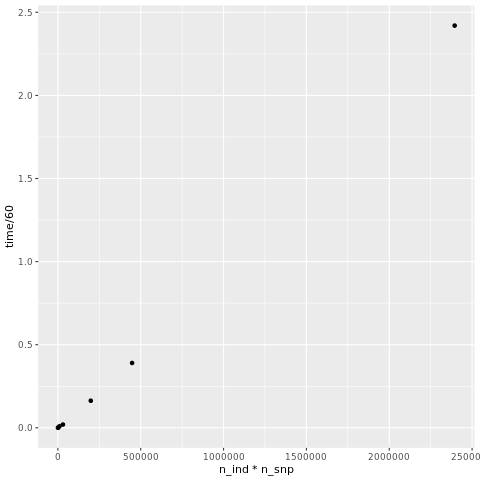

In [37]:
%%R -i df

df %>% 
    ggplot(aes(x = n_ind*n_snp, y = time/60)) +
    geom_point() 

So, we can se that to simulate GL for 10,000 individuals it takes less than 3 min. 

## 4. Further improvements

1. Introduce potential errors to invariable sites
2. Make possible a different reference sequence such that we do not need to assume that A = anc and C = der.
3. Check the order of individuals since nodes can be messed up. Check if the index of nodes it always goes from 0 to # nodes and are sorted in genotype matrix accordingly.
4. ~allow any ploidy~

## 5. Testing GL calculation

To test that the computation of genotype likelihoods is correct, I'll compare to the results obtained with other programs (`angsd` and `bcftools`). 

For that, I'll first fake a test dataset in which there is only a single read "A" for a single position. The error rate is assumed to be $e = 0.05012$ since it corresponds to the ACII value "." in phred scale based 33 as it is explained in this [link](https://www.drive5.com/usearch/manual/quality_score.html). This is because the input of those programs is with the ACII coded error rates.

The genotype read alleles counts is the following:

In [172]:
test = np.array([[[1, 0, 0, 0]]])
test

array([[[1, 0, 0, 0]]])

### 5.1. Testing GL calculation by `allelereadcounts_to_GL()` function

In [173]:
allelereadcounts_to_GL(test, e = 0.05012)[0, 0, :]

array([0.        , 0.67571188, 0.67571188, 0.67571188, 4.04052782,
       4.04052782, 4.04052782, 4.04052782, 4.04052782, 4.04052782])

### 5.2. GL from `angsd`

First, I'll creat a function `allelereadcounts_to_pileup()` that takes the "allelereadcounts" format and formats it to "pileup" in order to input the file to `angsd`. Furthermore, to be able to run `angsd` to compute GL, we need a fasta.fa.fai. Thus, I'm going to create a function `create_fasta()` that will create a fasta file representing the reference sequence. From that file, using `samtools faidx` I will create its index.

In [170]:
%%bash

mkdir -p tmp

In [174]:
def allelereadcounts_to_pileup(allelereadcounts, filename = "tmp/reads.pileup"):
    with open(filename, "w") as out:
        first_line = True
        for i in range(allelereadcounts.shape[0]):
            line = "1\t"+str(i+1)+"\tN"
            for j in range(allelereadcounts.shape[1]):
                nreads = allelereadcounts[i, j, :].sum()
                line = line+"\t"+str(nreads)+"\t"
                if nreads:
                    for c, b in zip(allelereadcounts[i, j, :], ["A", "C", "G", "T"]):
                        line = line+c*b
                    line = line+"\t"+"."*nreads
                else:
                    line = line+"\t*\t*"
            out.write(line+"\n")

def create_fasta(length = 100_000, filename = "tmp/fasta.fa"):
    with open(filename, "w") as fasta:
        fasta.write(">1\n")
        for i in range(0, length, 50):
            fasta.write("{}\n".format("A"*50))
        
allelereadcounts_to_pileup(test)
create_fasta(100_000)

In [175]:
%%bash

wc -l tmp/reads.pileup
head tmp/reads.pileup
gzip -c tmp/reads.pileup > tmp/reads.pileup.gz


1 tmp/reads.pileup
1	1	N	1	A	.


In [21]:
%%bash

samtools faidx tmp/fasta.fa

As we can see, there is a single read in position 1 for a single individual which corresponds to allele "A" with quality "." that corresponds to $e = 0.05012$. We are ready to run `angsd`.

In [176]:
%%bash

time angsd -GL 2                       \
           -pileup tmp/reads.pileup.gz \
           -fai    tmp/fasta.fa.fai    \
           -out    tmp/angsdput        \
           -doGlf  4                   \
           -nind   1

	-> angsd version: 0.935-53-gf475f10 (htslib: 1.14) build(Dec 13 2021 09:22:17)
	-> angsd -GL 2 -pileup tmp/reads.pileup.gz -fai tmp/fasta.fa.fai -out tmp/angsdput -doGlf 4 -nind 1 
	-> Inputtype is pileup
	-> You are using -pileup, this means:
	-> 1) Internal positions both from front and back is coded to 255
	-> 2) All mapping qualities (mapQ) are set to 30
	-> 3) Program will not represent insertions, use raw BAM/CRAM for that
	-> Done reading data waiting for calculations to finish
	-> Done waiting for threads
	-> Output filenames:
		->"tmp/angsdput.arg"
		->"tmp/angsdput.glf.gz"
	-> Mon Jan 17 13:27:42 2022
	-> Arguments and parameters for all analysis are located in .arg file
	-> Total number of sites analyzed: 1
	-> Number of sites retained after filtering: 1 
	[ALL done] cpu-time used =  0.00 sec
	[ALL done] walltime used =  0.00 sec

real	0m0.022s
user	0m0.005s
sys	0m0.007s


In [178]:
%%bash

zcat tmp/angsdput.glf.gz

1	1	0.000000	-0.675712	-0.675712	-0.675712	-4.040555	-4.040555	-4.040555	-4.040555	-4.040555	-4.040555


### 5.3. GL from `bcftools`

In this case, I need to simulate a "sam" mapped file which will be transformed to "bam" to be inputed to `bcftools mpileup`.

In [26]:
def allelereadcounts_to_SAM(allelereadcounts):
    counts = 0
    for ind in range(allelereadcounts.shape[1]):
        with open("ind"+str(ind)+".sam", "w") as out:
            out.write("@SQ\tSN:1\tLN:100000\n")
            for pos in range(allelereadcounts.shape[0]):
                for bp, rep in zip(["A", "C", "G", "T"], allelereadcounts[pos, ind]):
                    for z in range(rep):
                        QNAME = str(ind)+"_"+str(pos)+"_"+str(counts)
                        FLAG  = "0"
                        RNAME = "1"
                        POS   = str(pos+1)
                        MAPQ  = "255"
                        CIGAR = "1M"
                        RNEXT = "*"
                        PNEXT = "0"
                        TLEN  = "0"
                        SEQ   = bp
                        QUAL  = "M"
                        counts += 1
                        out.write("\t".join([QNAME, FLAG, RNAME, POS, MAPQ, CIGAR, RNEXT, PNEXT, TLEN, SEQ, QUAL])+"\n")
                        
allelereadcounts_to_SAM(test)

In [27]:
%%bash

wc -l ind0.sam
head ind0.sam

2 ind0.sam
@SQ	SN:1	LN:100000
0_0_0	0	1	1	255	1M	*	0	0	A	M


In [28]:
%%bash

samtools view -bS ind0.sam > ind0.bam

In [29]:
%%bash

bcftools mpileup ind0.sam --no-reference 

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##bcftoolsVersion=1.14+htslib-1.14
##bcftoolsCommand=mpileup --no-reference ind0.sam
##contig=<ID=1,length=100000>
##ALT=<ID=*,Description="Represents allele(s) other than observed.">
##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Raw read depth">
##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">
##INFO=<ID=RPBZ,Number=1,Type=Float,Description="Mann-Whitney U-z test of Read Position Bias (closer to 0 is better)">
##INFO=<ID=MQBZ,Number=1,Type=Float,Description="Mann-Whitney U-z test of Mapping Quality Bias (closer to 0 is b

[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


I was not able to finish this part.

### 5.4. All results together and more testing

We can see that the GL derived from our function and `angsd` is very similar (let alone that they have oposite signs). I can't make much sense about the `bcftools` result which in the future I'll have a look. Then, I can try with a more complex example. In this case the individual is supposed to be still homozygote "CC".

In [179]:
test = Rg[0, 0, :].reshape(1, 1, 4)
test

array([[[ 1, 11,  0,  1]]])

In [180]:
allelereadcounts_to_GL(test, e = 0.05012)[0, 0, :]*-1

array([-40.40527819,  -4.06801469, -41.08099007, -37.71617413,
        -0.        ,  -7.43283064,  -4.06801469, -44.44580601,
       -41.08099007, -40.40527819])

In [181]:
allelereadcounts_to_pileup(test)

In [182]:
%%bash

gzip -c tmp/reads.pileup > tmp/reads.pileup.gz

time angsd -GL 2                       \
           -pileup tmp/reads.pileup.gz \
           -fai    tmp/fasta.fa.fai    \
           -out    tmp/angsdput        \
           -doGlf  4                   \
           -nind   1

zcat tmp/angsdput.glf.gz

1	1	-40.405546	-4.067993	-41.081259	-37.716416	0.000000	-7.432836	-4.067993	-44.446101	-41.081259	-40.405546


	-> angsd version: 0.935-53-gf475f10 (htslib: 1.14) build(Dec 13 2021 09:22:17)
	-> angsd -GL 2 -pileup tmp/reads.pileup.gz -fai tmp/fasta.fa.fai -out tmp/angsdput -doGlf 4 -nind 1 
	-> Inputtype is pileup
	-> You are using -pileup, this means:
	-> 1) Internal positions both from front and back is coded to 255
	-> 2) All mapping qualities (mapQ) are set to 30
	-> 3) Program will not represent insertions, use raw BAM/CRAM for that
	-> Done reading data waiting for calculations to finish
	-> Done waiting for threads
	-> Output filenames:
		->"tmp/angsdput.arg"
		->"tmp/angsdput.glf.gz"
	-> Mon Jan 17 13:36:52 2022
	-> Arguments and parameters for all analysis are located in .arg file
	-> Total number of sites analyzed: 1
	-> Number of sites retained after filtering: 1 
	[ALL done] cpu-time used =  0.00 sec
	[ALL done] walltime used =  0.00 sec

real	0m0.021s
user	0m0.009s
sys	0m0.003s


Very close.

Finally, let's try a heterozygote example.

In [185]:
test = np.array([[[1, 1, 16, 15]]])
allelereadcounts_to_pileup(test)
allelereadcounts_to_GL(test, e = 0.05012)[0, 0, :]*-1

array([-100.26876642,  -97.57966236,  -47.10742321,  -50.47223915,
       -100.26876642,  -47.10742321,  -50.47223915,  -39.66084913,
         -0.        ,  -43.70137695])

In [184]:
%%bash

gzip -c tmp/reads.pileup > tmp/reads.pileup.gz

time angsd -GL 2                       \
           -pileup tmp/reads.pileup.gz \
           -fai    tmp/fasta.fa.fai    \
           -out    tmp/angsdput        \
           -doGlf  4                   \
           -nind   1

zcat tmp/angsdput.glf.gz

1	1	-100.269557	-97.580427	-47.107792	-50.472634	-100.269557	-47.107792	-50.472634	-39.661237	0.000000	-43.701792


	-> angsd version: 0.935-53-gf475f10 (htslib: 1.14) build(Dec 13 2021 09:22:17)
	-> angsd -GL 2 -pileup tmp/reads.pileup.gz -fai tmp/fasta.fa.fai -out tmp/angsdput -doGlf 4 -nind 1 
	-> Inputtype is pileup
	-> You are using -pileup, this means:
	-> 1) Internal positions both from front and back is coded to 255
	-> 2) All mapping qualities (mapQ) are set to 30
	-> 3) Program will not represent insertions, use raw BAM/CRAM for that
	-> Done reading data waiting for calculations to finish
	-> Done waiting for threads
	-> Output filenames:
		->"tmp/angsdput.arg"
		->"tmp/angsdput.glf.gz"
	-> Mon Jan 17 13:37:02 2022
	-> Arguments and parameters for all analysis are located in .arg file
	-> Total number of sites analyzed: 1
	-> Number of sites retained after filtering: 1 
	[ALL done] cpu-time used =  0.00 sec
	[ALL done] walltime used =  0.00 sec

real	0m0.020s
user	0m0.008s
sys	0m0.004s


The results are pretty close, so we can assume that it is correct since it seems the error is about the rounding. 

In [36]:
%%bash 

rm -f tmp/*

### 5.5. Comparing all GL calculated by each method

In order to compare more sistematically the GL from both pipelines, I need to create a function that compares two arrays. Since the GL that I compute with `allelereadcounts_to_GL()` is already given in a numpy matrix, I'll first have to read in the output from `ANGSD` and format it in a numpy array. 

In [186]:
print(Rg.shape)
allelereadcounts_to_pileup(Rg)

(115, 5, 4)


In [187]:
%%bash

head tmp/reads.pileup

1	1	N	13	ACCCCCCCCCCCT	.............	15	CCCCCCCCCCCCGTT	...............	29	AAAAAAAAAAAAAAACCCCCCCCCCCCGT	.............................	12	CCCCCCCCCCCC	............	14	CCCCCCCCCCCCCG	..............
1	2	N	7	AAAAAAA	.......	15	AAAAAAAAAAAAAAA	...............	24	AAAAAAAAACCCCCCCCCCCCCCC	........................	13	AAAAAAAAAAAAA	.............	12	AAAAAAAAAACT	............
1	3	N	8	AAAACCGT	........	18	AAAAAAAAAAAACCCCCC	..................	25	AAAAAAAAAAAAACCCCCCCCCCCC	.........................	9	AAAAAACCC	.........	9	AAAAAAAAA	.........
1	4	N	7	CCCCCCC	.......	20	AAAAAAAAAAAACCCCCCCG	....................	20	ACCCCCCCCCCCCCCCCCCC	....................	21	CCCCCCCCCCCCCCCCCCCCC	.....................	7	CCCCCCC	.......
1	5	N	5	CCCCG	.....	21	AAAAAAAAAACCCCCCCCCCC	.....................	17	CCCCCCCCCCCCCCCCC	.................	6	CCCCCC	......	10	CCCCCCCCCC	..........
1	6	N	12	AAAAAAAAAAAA	............	17	AAAAACCCCCCCCCCCC	.................	21	AAAAAAAAAAAAAAAAAAAAA	.....................	15	AAAAAAAAAAAAAAA

In [188]:
%%bash

gzip -c tmp/reads.pileup > tmp/reads.pileup.gz

time angsd -GL 2                       \
           -pileup tmp/reads.pileup.gz \
           -fai    tmp/fasta.fa.fai    \
           -out    tmp/angsdput        \
           -doGlf  4                   \
           -nind   5

zcat tmp/angsdput.glf.gz > tmp/angsdput.glf
head -n 2 tmp/angsdput.glf
awk '{}END{print "Number of rows    = "NR"\nNumber of columns = "NF}' tmp/angsdput.glf

1	1	-40.405546	-4.067993	-41.081259	-37.716416	0.000000	-7.432836	-4.067993	-44.446101	-41.081259	-40.405546	-48.486656	-8.108548	-45.121813	-41.756971	0.000000	-4.743706	-1.378863	-44.446101	-38.392129	-40.405546	-30.242422	0.000000	-37.013265	-37.013265	-42.364086	-47.107792	-47.107792	-86.810187	-84.121057	-86.810187	-48.486656	-8.108548	-48.486656	-48.486656	0.000000	-8.108548	-8.108548	-48.486656	-48.486656	-48.486656	-52.527210	-8.784260	-49.162368	-52.527210	0.000000	-5.419418	-8.784260	-48.486656	-49.162368	-52.527210
1	2	0.000000	-4.729986	-4.729986	-4.729986	-28.283882	-28.283882	-28.283882	-28.283882	-28.283882	-28.283882	0.000000	-10.135685	-10.135685	-10.135685	-60.608320	-60.608320	-60.608320	-60.608320	-60.608320	-60.608320	-44.391223	0.000000	-50.472634	-50.472634	-20.147896	-30.283581	-30.283581	-80.756215	-80.756215	-80.756215	0.000000	-8.784260	-8.784260	-8.784260	-52.527210	-52.527210	-52.527210	-52.527210	-52.527210	-52.527210	0.000000	-3.392281	-6.757123	-3.392281

	-> angsd version: 0.935-53-gf475f10 (htslib: 1.14) build(Dec 13 2021 09:22:17)
	-> angsd -GL 2 -pileup tmp/reads.pileup.gz -fai tmp/fasta.fa.fai -out tmp/angsdput -doGlf 4 -nind 5 
	-> Inputtype is pileup
	-> You are using -pileup, this means:
	-> 1) Internal positions both from front and back is coded to 255
	-> 2) All mapping qualities (mapQ) are set to 30
	-> 3) Program will not represent insertions, use raw BAM/CRAM for that
	-> Done reading data waiting for calculations to finish
	-> Done waiting for threads
	-> Output filenames:
		->"tmp/angsdput.arg"
		->"tmp/angsdput.glf.gz"
	-> Mon Jan 17 13:37:28 2022
	-> Arguments and parameters for all analysis are located in .arg file
	-> Total number of sites analyzed: 115
	-> Number of sites retained after filtering: 115 
	[ALL done] cpu-time used =  0.01 sec
	[ALL done] walltime used =  0.00 sec

real	0m0.048s
user	0m0.019s
sys	0m0.002s


In [189]:
def read_angsd_gl(file = "tmp/angsdput.glf"):
    angsd_gl = []
    with open(file, "r") as f:
        for line in f:
            angsd_gl.append(np.array(line.strip().split()[2:]).reshape(5, 10).astype(np.float64).tolist())
    return -np.array(angsd_gl)
    
angsd_gl = read_angsd_gl()
print(angsd_gl.shape)
#print(angsd_gl)

(115, 5, 10)


In [190]:
moi_gl = allelereadcounts_to_GL(Rg, e = 0.05012)
print(moi_gl.shape)
#print(moi_gl)

(115, 5, 10)


In [191]:
angsd_gl[0, 0, :]

array([40.405546,  4.067993, 41.081259, 37.716416, -0.      ,  7.432836,
        4.067993, 44.446101, 41.081259, 40.405546])

In [192]:
moi_gl[0, 0, :]

array([40.40527819,  4.06801469, 41.08099007, 37.71617413,  0.        ,
        7.43283064,  4.06801469, 44.44580601, 41.08099007, 40.40527819])

In [193]:
def msqrd(a, b):
    return np.power(a-b, 2).sum()/a.size

msqrd(angsd_gl, moi_gl)

9.701684647512939e-08

## 6. GL vectorization and generalization

Taking the GATK formula:

![Gl](GL.png)

We see that it is specific for diploid genotypes. If we were to generalize this aspect, we can compute the GL as:

$$
GL = Pr(D|G) = \prod_{i=1}^{R}\sum_{j=1}^{A} \frac{1}{A} Pr(r_i | a_j) 
$$

Note: $R$ denotes the number of reads, $A$ denotes the number of haplotypic chromosomes; as follows, $r_i$ is the base pair corresponding to read $i$ and $a_j$ is the base pair of the $j$ haplotype of the genotype $G$.

The probability function is the same as before:

$$
Pr(r_i | a_j) = 
\begin{cases}
    1-e         & \text{if } r_i = a_j\\
    \frac{e}{3} & \text{otherwise}
\end{cases}
$$

Thus, to compute the $GL = AA$ when there are two reads $R = AA$ can be conputed with the following formula:




$$
\left(\frac{1}{A} Pr(r_1 = A | a_1 = A) + \frac{1}{A} Pr(r_1 = A | a_2 = A) \right) * \left(\frac{1}{A} Pr(r_2 = A | a_1 = A) + \frac{1}{A} Pr(r_2 = A | a_2 = A) \right) 
$$

$$
\left(\frac{1}{2} (1-e) + \frac{1}{2} (1-e) \right) * \left(\frac{1}{2} (1-e) + \frac{1}{2} (1-e) \right) 
$$

if instead I had $R = AC$ 

$$
\left(\frac{1}{A} Pr(r_1 = A | a_1 = A) + \frac{1}{A} Pr(r_1 = A | a_2 = A) \right) * \left(\frac{1}{A} Pr(r_2 = C | a_1 = A) + \frac{1}{A} Pr(r_2 = C | a_2 = A) \right) 
$$

$$
\left(\frac{1}{2} (1-e) + \frac{1}{2} (1-e) \right) * \left(\frac{1}{2} \frac{e}{3} + \frac{1}{2} \frac{e}{3} \right) 
$$

Finally, if we get $R = AC$  and calculate GL for $G = AC$

$$
\left(\frac{1}{A} Pr(r_1 = A | a_1 = A) + \frac{1}{A} Pr(r_1 = A | a_2 = C) \right) * \left(\frac{1}{A} Pr(r_2 = C | a_1 = A) + \frac{1}{A} Pr(r_2 = C | a_2 = C) \right) 
$$

$$
\left(\frac{1}{2} (1-e) + \frac{1}{2} \frac{e}{3} \right) * \left(\frac{1}{2} \frac{e}{3} + \frac{1}{2} (1-e) \right) 
$$

The patern I identify here is that for a given read $r_i$, we are going to have as many instances of $1-e$ as $A == r_i$, and as many as $\frac{e}{3}$ as  $A != r_i$. Thus, for the case of a read $r_i = A$ and calculating $G = AA$:

$$
\left(\frac{1}{A} Pr(r_1 = A | a_1 = A) + \frac{1}{A} Pr(r_1 = A | a_2 = A) \right) 
$$
$$
\#A == r_i \left(\frac{1}{A} Pr(r_1 = A | a_1 = A) \right)
$$

Thus, we can take out the term $\frac{1}{A}$

$$
\frac{\#A == r_i}{A} \left(Pr(r_1 = A | a_1 = A) \right)
$$

And thus, the first term, takes the form of a frequency: is the frequency of alleles in the genotype that are the same as in the read analysed.

What about the case where $G = AC$:

$$
\left(\frac{1}{A} Pr(r_1 = A | a_1 = A) + \frac{1}{A} Pr(r_1 = A | a_2 = C) \right)
$$

Now, I have to introduce the instances where an allele is not the same as the read.

$$
\frac{\#A == r_i}{A} \left(Pr(r_1 = A | a_1 = A) \right) + \frac{A != r_i}{A} \left(Pr(r_1 = A | a_1 = C) \right)
$$

Because this exact calculation is going to be repeated and multiply to the result of the previous ones as many times as reads of the same kind, we can:

$$
\prod_{b = 1}^{B}{\frac{\#A == b}{A} \left(Pr(r | a ) \right) + \frac{A != b}{A} \left(Pr(r | a ) \right)} ^ {\#R == b}
$$

$$
B = \{A, C, G, T\}
$$

So, we have a generalized way to compute likelyhoods for any given ploidy. 

Because we are going to apply `log()` we can refurmulate such that there is sumation instead of multiplication of very small numbers that could lead to various problems.



In [111]:
from itertools import combinations_with_replacement

def allelereadcounts_to_vGL(allelereadcounts, e, ploidy = 2):
    GTxploidy    = np.array([list(x) for x in combinations_with_replacement([0, 1, 2, 3], ploidy)])
    AFxGTxploidy = np.array([(GTxploidy == 0).sum(axis = 1), (GTxploidy == 1).sum(axis = 1), (GTxploidy == 2).sum(axis = 1), (GTxploidy == 3).sum(axis = 1)])/ploidy
    
    GL_vec = np.multiply(-np.log(AFxGTxploidy*(1-e)+(1-AFxGTxploidy)*(e/3)), allelereadcounts.reshape(allelereadcounts.shape[0], allelereadcounts.shape[1], allelereadcounts.shape[2], 1)).sum(axis = 2)
    return GL_vec-GL_vec.min(axis = 2).reshape(GL_vec.shape[0], GL_vec.shape[1], 1)

GL_vec = allelereadcounts_to_vGL(Rg, e = 0.05012)
print(GL_vec.shape)
GL_vec[1, 1, :]

(192, 50, 10)


array([  0.        ,  26.35276317,  26.35276317,  26.35276317,
       157.58058496, 157.58058496, 157.58058496, 157.58058496,
       157.58058496, 157.58058496])

In [205]:
GL = allelereadcounts_to_GL(Rg, e = 0.05012)
GL[1, 1, :]

array([ 0.        , 10.13567814, 10.13567814, 10.13567814, 60.60791729,
       60.60791729, 60.60791729, 60.60791729, 60.60791729, 60.60791729])

We can see that the likelihoods computed using the vectorized and the nonvectorized function look the same. We can now compute the mean squared difference between the two computations.

In [206]:
msqrd(GL_vec, GL)

2.0900012226325034e-29

And they are esentially the same. 

## 6.1. GL vectorization running time comparison

In [207]:
%%time
n      = 5000
ploidy = 2
e      = 0.05

ns = [100, 500, 750, 1000, 2000, 5000]
xs = []
tl = []
tv = []
for n in ns:
    
    print("Iteration N = ", n)
    print("Start simulations", flush=True)
    start_time = time.time()
    ts = sim(seeds=(1, 2), n = n)
    print("Done:", time.time()-start_time)
    xs.append(ts.num_mutations)
    
    print("Start arc simulations", flush=True)
    start_time = time.time()
    Rg = sim_allelereadcounts(ts, mean_depth = 30., std_depth = 5., e = 0.05, seed = 1234)
    print("Done:", time.time()-start_time)

    print("Start linear", flush=True)
    start_time = time.time()
    allelereadcounts_to_GL(Rg, e = 0.05)
    tl.append(time.time()-start_time)
    print("Linear:", tl[-1])

    print("Start vector", flush=True)
    start_time = time.time()
    allelereadcounts_to_vGL(Rg, e = 0.05)
    tv.append(time.time()-start_time)
    print("Vector:", tv[-1])


Iteration N =  100
Start simulations
Done: 0.009607791900634766
Start arc simulations
Done: 0.7697646617889404
Start linear
Linear: 0.027658700942993164
Start vector
Vector: 0.011827707290649414
Iteration N =  500
Start simulations
Done: 0.009420633316040039
Start arc simulations
Done: 5.600864887237549
Start linear
Linear: 0.17894601821899414
Start vector
Vector: 0.07600045204162598
Iteration N =  750
Start simulations
Done: 0.009377002716064453
Start arc simulations
Done: 7.822070360183716
Start linear
Linear: 0.25345325469970703
Start vector
Vector: 0.1135401725769043
Iteration N =  1000
Start simulations
Done: 0.011180639266967773
Start arc simulations
Done: 12.009470224380493
Start linear
Linear: 0.3964712619781494
Start vector
Vector: 0.2051684856414795
Iteration N =  2000
Start simulations
Done: 0.015138864517211914
Start arc simulations
Done: 24.607510805130005
Start linear
Linear: 0.9297971725463867
Start vector
Vector: 0.4570603370666504
Iteration N =  5000
Start simulations


In [211]:
df = pd.DataFrame({"n_ind" : ns, "n_snp" : xs, "forloop" :tl, "vector" : tv})
df

,n_ind,n_snp,forloop,vector
0,100,303,0.027659,0.011828
1,500,397,0.178946,0.076000
2,750,388,0.253453,0.113540
3,1000,448,0.396471,0.205168
4,2000,458,0.929797,0.457060
5,5000,479,2.736018,1.833445


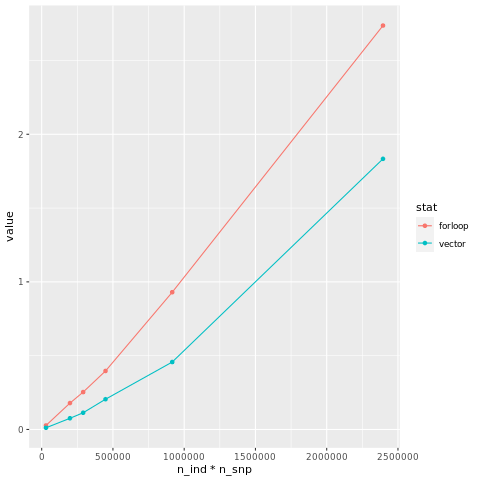

In [220]:
%%R -i df

df %>% 
    gather(stat, value, "forloop", "vector") %>%
    ggplot(aes(x = n_ind*n_snp, y = value, color = stat)) +
    geom_point() +
    geom_line()

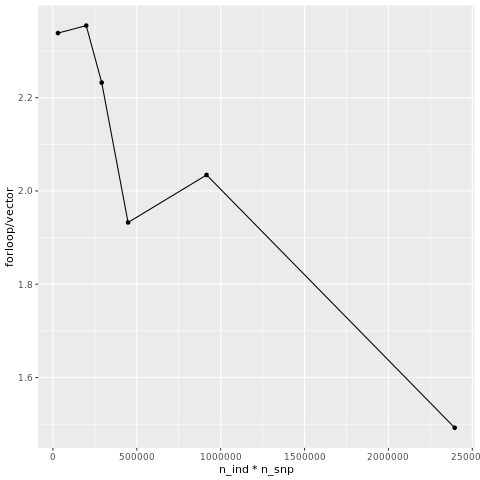

In [219]:
%%R

df %>% 
    ggplot(aes(x = n_ind*n_snp, y = forloop/vector)) +
    geom_point() +
    geom_line()

## 7. Include monomorphic sites

The genotype matrix outputed by `tskit` package contains only polymorphic sites. Because sequencing errors can happen in monomorphic sites, I will construct a function that will return a genotype matrix that includes those sites given a minimum and maximum position of the region analyzed and an array with the positions for the polymorphic sites included in the original genotype matrix. 

In [15]:
ts  = sim(seeds=(1, 2)) 
gm  = ts.genotype_matrix()
pos = np.array(ts.tables.sites.position)
print(gm.shape, pos.shape)
print(pos)

(115, 10) (115,)
<class 'numpy.ndarray'>


In [18]:
def incorporate_monomorphic(poly_gm, pos, start, end):
    gm = np.zeros((end-start, poly_gm.shape[1]))
    gm[pos.astype(int)] = poly_gm
    return gm
    
    
incorporate_monomorphic(gm, pos, 0, 100_000)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

> Comments 

- Is it [start, end] or [start, end) or (start, end)
- Is position starting in 1 or 0?

## 8. Compute Major minor allele likelihoods

In [215]:
import numpy as np
from itertools import combinations_with_replacement
from itertools import combinations
from scipy.stats import binom
ploidy = 2
GTxploidy    = np.array([list(x) for x in combinations_with_replacement([0, 1, 2, 3], ploidy)])
Mmxploidy    = np.array([list(x) for x in combinations([0, 1, 2, 3], 2)])

print(Mmxploidy)
print(GTxploidy)

[[0 1]
 [0 2]
 [0 3]
 [1 2]
 [1 3]
 [2 3]]
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 1]
 [1 2]
 [1 3]
 [2 2]
 [2 3]
 [3 3]]


In [216]:
pGTxMm = []
#For every genotype (GT)
for i in range(GTxploidy.shape[0]):
    pGTxMm_tmp = []
    #For every combination of major (M) and minor (m) alleles (M and m can't be the same allele and there can be only two)
    for j in range(Mmxploidy.shape[0]):
        #All alleles in GT are either M or m
        all_GT_in_Mm = (np.isin(GTxploidy[i],  Mmxploidy[j]).sum() == ploidy)*1
        #Probability of the genotype given M and m only possible alleles
        p_GT = binom.pmf((GTxploidy[i] == Mmxploidy[j, 0]).sum(), ploidy, 0.5)
        pGTxMm_tmp.append( p_GT * all_GT_in_Mm )
    pGTxMm.append(np.array(pGTxMm_tmp))
pGTxMm = np.array(pGTxMm)
print(pGTxMm.shape)
pGTxMm

(10, 6)


array([[0.25, 0.25, 0.25, 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.5 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.  ],
       [0.25, 0.  , 0.  , 0.25, 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.5 , 0.  ],
       [0.  , 0.25, 0.  , 0.25, 0.  , 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.25, 0.  , 0.25, 0.25]])

In [242]:
e = 0.05
ts = sim(seeds=(1, 2), n = 10)
ref = np.array([v.site.ancestral_state for v in ts.variants()])
alt = np.array([v.site.mutations[0].derived_state for v in ts.variants()])
gm  = ts.genotype_matrix()
arc = sim_allelereadcounts(gm, ref = ref, alt = alt, mean_depth = 50., std_depth = 3., e = e, ploidy = 2, seed = 1234)
gl  = allelereadcounts_to_GL(arc, e = e)


print(gl[0, 0])
(gl[0, 0].reshape(10, 1) * pGTxMm).sum(axis = 0)

[144.11796525  67.3459166   74.08050826 141.42642486  55.17083736
   0.          67.3459166   63.25693989  74.08050826 144.11796525]


array([ 83.49515895,  88.88398042, 142.77219506,  29.60694431,
        83.49515895,  88.88398042])

In [243]:
gl.shape

(173, 10, 10)

In [244]:
gl

array([[[144.11796525,  67.3459166 ,  74.08050826, ...,  63.25693989,
          74.08050826, 144.11796525],
        [190.02340959, 191.37492046,  26.37742479, ...,   0.        ,
          33.11201645, 198.10951212],
        [283.01358875, 283.01358875,  47.30288065, ...,   0.        ,
          37.20099316, 270.88443494],
        ...,
        [129.37764057, 129.37764057,  21.62417401, ...,   0.        ,
          14.88958235, 121.29153804],
        [190.02340959, 187.3318692 ,  29.06896519, ...,   0.        ,
          29.06896519, 190.02340959],
        [154.89560818,  43.77484579, 111.12076239, ..., 102.3359417 ,
         111.12076239, 154.89560818]],

       [[  0.        ,  39.86957083,  39.86957083, ..., 238.5400248 ,
         235.17272897, 234.49697353],
        [  0.        ,  31.77198694,  35.13928277, ..., 210.23866593,
         206.8713701 , 206.19561466],
        [  0.        ,  33.12349781,  26.38890615, ..., 206.19561466,
         208.22288097, 218.32476846],
        ...,


In [245]:
gl.reshape(gl.shape[0], gl.shape[1], gl.shape[2], 1).shape

(173, 10, 10, 1)

In [246]:
Mmresult = np.argmin((gl.reshape(gl.shape[0], gl.shape[1], gl.shape[2], 1) * pGTxMm.reshape(1, 1, pGTxMm.shape[0], pGTxMm.shape[1])).sum(axis = 2).prod(axis = 1), axis = 1)
Mmresult

array([3, 0, 4, 1, 0, 2, 5, 2, 2, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 5, 4, 4,
       1, 0, 0, 3, 0, 4, 2, 1, 4, 1, 4, 4, 0, 0, 4, 1, 0, 1, 1, 2, 4, 1,
       3, 4, 4, 1, 0, 2, 0, 5, 4, 1, 0, 1, 5, 0, 0, 5, 2, 5, 3, 3, 3, 3,
       5, 4, 2, 1, 4, 5, 3, 3, 2, 1, 0, 1, 4, 3, 3, 0, 4, 4, 2, 4, 5, 5,
       3, 0, 2, 5, 1, 2, 1, 3, 5, 1, 2, 4, 1, 5, 0, 1, 1, 4, 0, 0, 3, 0,
       1, 3, 4, 1, 0, 2, 2, 5, 4, 3, 3, 1, 3, 5, 0, 1, 2, 4, 4, 0, 5, 1,
       1, 0, 0, 2, 2, 3, 3, 2, 3, 3, 3, 4, 0, 5, 4, 5, 1, 0, 3, 5, 2, 4,
       1, 4, 0, 4, 1, 4, 4, 1, 3, 1, 3, 2, 5, 1, 0, 5, 1, 0, 3])

In [247]:
ra = {"A" : {"C" : 0,
             "G" : 1, 
             "T" : 2},
      "C" : {"G" : 3,
             "T" : 4},
      "G" : {"T" : 5}}
transform = []
for r, a in zip(ref, alt):
    if r < a:
        transform.append(ra[r][a])
    else:
        transform.append(ra[a][r])
print(ref[23], alt[23])
print(transform[23])
print(Mmresult[23])
(np.array(transform) == Mmresult)

A C
0
0


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [236]:
arc[23]

array([[11,  0,  0,  1],
       [16,  0,  0,  0],
       [21,  2,  1,  1],
       [14,  0,  0,  0],
       [12,  0,  2,  1],
       [17,  0,  0,  0],
       [ 9,  2,  2,  2],
       [ 6,  0,  0,  0],
       [22,  0,  0,  1],
       [11,  0,  0,  0]])

In [223]:
"A" > "C"

False

In [191]:
arc = np.array([[[0, 0, 0, 0]]])
print(arc.shape)
gl  = allelereadcounts_to_vGL(arc, e = 0.05)
print(gl[0, 0])
(gl[0, 0].reshape(10, 1) * pGTxMm).sum(axis = 0)

(1, 1, 4)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0., 0., 0., 0., 0., 0.])

In [193]:
np.argmin((gl.reshape(gl.shape[0], gl.shape[1], gl.shape[2], 1) * pGTxMm.reshape(1, 1, pGTxMm.shape[0], pGTxMm.shape[1])).sum(axis = 2).prod(axis = 1), axis = 1)

array([0])

In [ ]:
import numpy as np
from itertools import combinations_with_replacement
from itertools import combinations
from scipy.stats import binom

def get_pGTxMm(ploidy = 2):
    GTxploidy    = np.array([list(x) for x in combinations_with_replacement([0, 1, 2, 3], ploidy)])
    Mmxploidy    = np.array([list(x) for x in combinations([0, 1, 2, 3], 2)])
    pGTxMm = []
    #For every genotype (GT)
    for i in range(GTxploidy.shape[0]):
        pGTxMm_tmp = []
        #For every combination of major (M) and minor (m) alleles (M and m can't be the same allele and there can be only two)
        for j in range(Mmxploidy.shape[0]):
            #All alleles in GT are either M or m
            all_GT_in_Mm = (np.isin(GTxploidy[i],  Mmxploidy[j]).sum() == ploidy)*1
            #Probability of the genotype given M and m only possible alleles
            p_GT = binom.pmf((GTxploidy[i] == Mmxploidy[j, 0]).sum(), ploidy, 0.5)
            pGTxMm_tmp.append( p_GT * all_GT_in_Mm )
        pGTxMm.append(np.array(pGTxMm_tmp))
    return np.array(pGTxMm)

def gl_to_Mm(gl, ploidy = 2)
    pGTxMm = get_pGTxMm(ploidy)
    return np.argmin((gl.reshape(gl.shape[0], gl.shape[1], gl.shape[2], 1) * pGTxMm.reshape(1, 1, pGTxMm.shape[0], pGTxMm.shape[1])).sum(axis = 2).prod(axis = 1), axis = 1)

## 9. Linked depth

### 9.1 create function

In [5]:
def linked_depth(rng, DPh, read_length, sites_n):
    '''
    Simulates reads in a contiguous genomic region to compute the depth per position.
    
    Parameters
    ----------
    rng : `numpy.random._generator.Generator` 
        random number generation numpy object
    DPh : `numpy.ndarray`
        Numpy array with the depth per haplotype
    read_length : `int`
        Read length in base pair units
    sites_n : `int`
        number of sites that depth has to be simulated for
    
    Returns 
    -------
    DP : `numpy.ndarray`
        Depth per site per haplotype
    '''
    DP = []
    read_n     = ((DPh*sites_n)/read_length).astype("int")
    for r in read_n:
        dp = np.zeros((sites_n,), dtype=int)
        for p in rng.integers(low=0, high=sites_n-read_length+1, size=r):
            dp[p:p+read_length] += 1
        DP.append(dp.tolist())
    return np.array(DP).T

def independent_depth(rng, DPh, size):
    '''
    Returns depth per position per haplotype (size[0], size[1]) drawn from the "rng" from a Poisson 
    distribution with a lambda value "DPh" per haplotype
    '''
    return rng.poisson(DPh, size=size)

gm  = np.array([[1, 0, 0, 0], [1, 1, 1, 0]])
DPh = np.array([5]*5)
rng = np.random.default_rng(1234)
linked_depth(rng, DPh, read_length = 100, sites_n = 300)

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

In [9]:
independent_depth(rng, DPh, size = (300, 5))

array([[5, 6, 2, 4, 6],
       [6, 3, 2, 2, 2],
       [6, 3, 3, 4, 4],
       ...,
       [6, 3, 4, 4, 8],
       [2, 3, 4, 2, 2],
       [7, 5, 5, 5, 3]])

### 9.2 create function to truncate edge effect

In [ ]:
def linked_depth(rng, DPh, read_length, sites_n):
    '''
    Simulates reads in a contiguous genomic region to compute the depth per position.
    
    Parameters
    ----------
    rng : `numpy.random._generator.Generator` 
        random number generation numpy object
    DPh : `numpy.ndarray`
        Numpy array with the depth per haplotype
    read_length : `int`
        Read length in base pair units
    sites_n : `int`
        number of sites that depth has to be simulated for
    
    Returns 
    -------
    DP : `numpy.ndarray`
        Depth per site per haplotype
    '''
    seq_length = sites_n+(2*read_length)
    DP         = []
    print(sites_n+(2*read_length))
    read_n     = (DPh*seq_length/read_length).astype("int")
    for r in read_n:
        dp = np.zeros((seq_length,), dtype=int)
        for p in rng.integers(low=0, high=seq_length-read_length+1, size=r):
            dp[p:p+read_length] += 1
        DP.append(dp.tolist())
    DP = (np.array(DP).T)[(1*read_length):(-1*read_length), :]
    return np.round(DP-((DP.mean(axis = 0)-5).repeat(DP.shape[0]).reshape(DP.shape)))

rng = np.random.default_rng()
DPh = np.array([5] * 500)  # 500 haplotypes each with depth 5
linked = linked_depth(rng, DPh, 100, 300)

### 9.3 Explore real data

In [20]:
qual = '!"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~'
phred = {}

for i, q in enumerate(qual):
    phred[q] = i

In [21]:
readnum = []
positio = []
quality = []
end = None
with open("/Users/au552345/Desktop/readquality.txt") as file:
    for i, line in enumerate(file):
        start, qual = line.strip().split()
        start = int(start)

        if end != None:
            if end < start:
                for p in range(end+1, start):
                    readnum.append(-1)
                    positio.append(p)
                    quality.append(0)

        for q in qual:
            readnum.append(i)
            positio.append(start)
            quality.append(phred[q])
            start += 1
            end = start
        if i > 10000:
            break

In [22]:
df = pd.DataFrame({"readnum" : readnum,
                   "positio" : positio,
                   "quality" : quality})

In [23]:
with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10):
    print(df[df["readnum"] == -1])

Empty DataFrame
Columns: [readnum, positio, quality]
Index: []


In [24]:
%R -i df

In [25]:
%%R

df %>%
    filter(positio >= 1000050, positio <= 1037550) -> df

In [26]:
%%R 

df %>%
    head()

     readnum positio quality
1960      12 1000050      27
1961      12 1000051      22
1962      12 1000052      27
2106      13 1000050      33
2107      13 1000051      22
2108      13 1000052      33


#### check read length

In [19]:
%%R

df %>% 
    count(readnum) %>%
    mutate(depthx10 = trunc(n/10)) %>%
    count(depthx10) %>%
    mutate(min_len = (depthx10*10)+1, max_len = (depthx10+1)*10, perc = n*100/sum(n)) %>%
    select(min_len, max_len, n, perc)
    

   min_len max_len    n        perc
1        1      10    5  0.05254309
2       11      20    4  0.04203447
3       21      30    8  0.08406894
4       31      40  129  1.35561160
5       41      50   18  0.18915511
6       51      60    7  0.07356032
7       61      70   10  0.10508617
8       71      80    9  0.09457755
9       81      90   10  0.10508617
10      91     100    6  0.06305170
11     101     110    6  0.06305170
12     111     120    3  0.03152585
13     121     130    3  0.03152585
14     131     140    3  0.03152585
15     141     150    2  0.02101723
16     151     160 9293 97.65657839


#### check depth

mean depth

In [20]:
%%R

df %>% 
    count(positio) %>%
    pull(n) %>%
    mean()

[1] 37.70846


depth per position

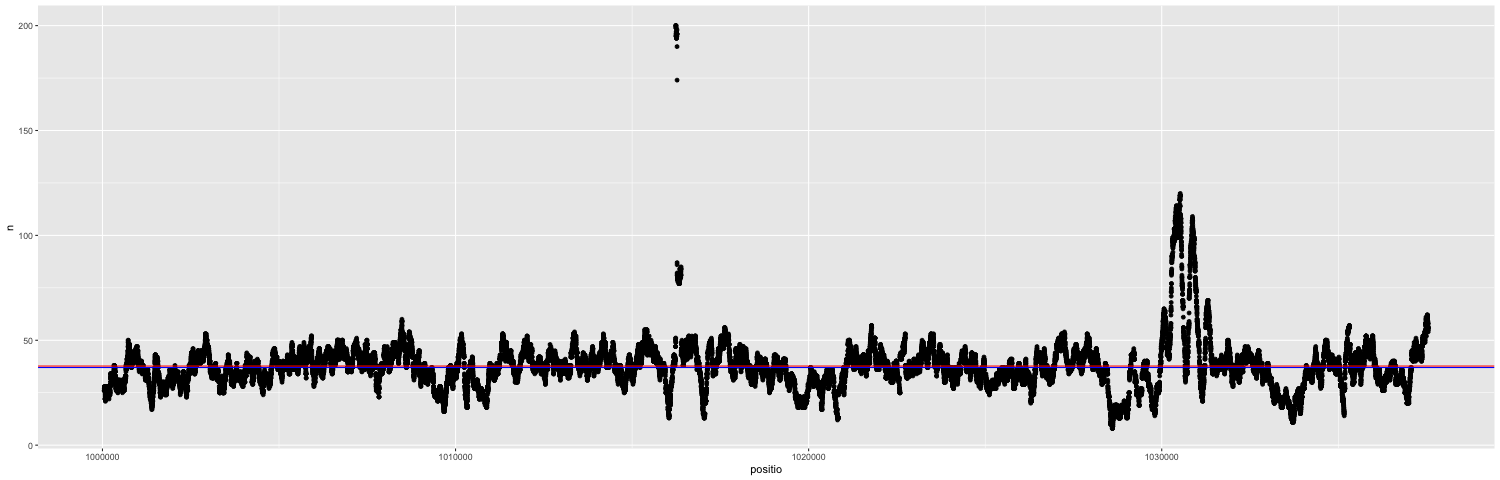

In [21]:
%%R --width 1500

df %>% 
    count(positio) %>%
    ggplot() +
    geom_point(aes(x = positio, y = n)) +
    geom_hline(aes(yintercept = mean(n)), color = "red") +
    geom_hline(aes(yintercept = median(n)), color = "blue")

In [22]:
%%R

print(head(df))
tail(df)

     readnum positio quality
1960      12 1000050      27
1961      12 1000051      22
1962      12 1000052      27
2106      13 1000050      33
2107      13 1000051      22
2108      13 1000052      33
        readnum positio quality
1422300    9525 1037550      33
1422443    9526 1037548      22
1422444    9526 1037549      27
1422445    9526 1037550      27
1422594    9527 1037549      27
1422595    9527 1037550      33


In [23]:
1037550-1000052

37498

Expected under Poisson and observed

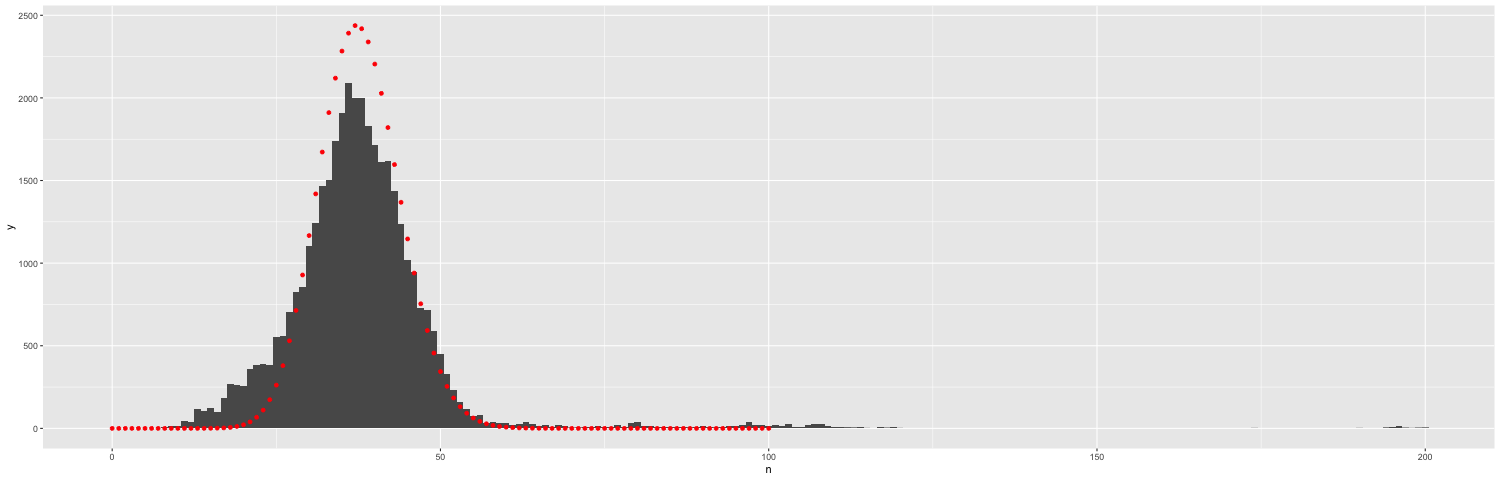

In [24]:
%%R --width 1500

df %>% 
    count(positio) %>%
    ggplot() +
    geom_histogram(aes(x = n), binwidth = 1) +
    geom_point(data = data.frame(x = 0:100, y = dpois(x = 0:100, lambda = 37.70846)*37498), aes(x = x, y = y), color = "red")

Measure of autocorrelation as the difference in depth from each position to the next one

a) per position

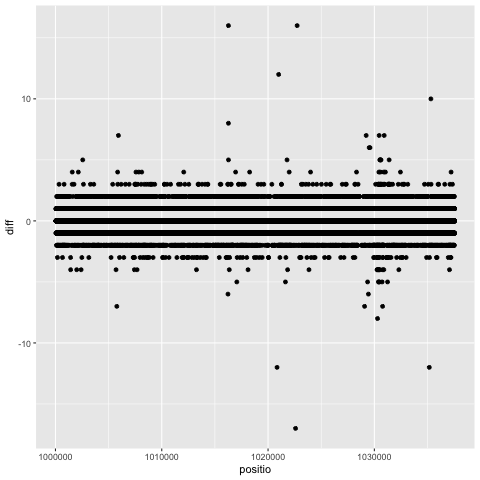

In [25]:
%%R

df %>% 
    count(positio) %>%
    arrange(positio) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    filter(diff < 25, diff > -25) %>%
    ggplot() +
    geom_point(aes(x = positio, y = diff))

b) as a histogram

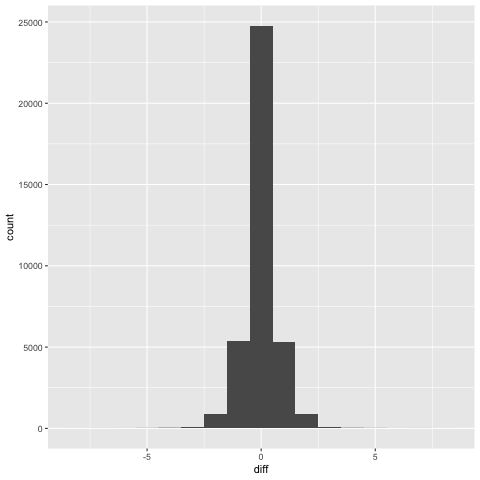

In [208]:
%%R

df %>% 
    count(positio) %>%
    arrange(positio) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    filter(diff < 10, diff > -10) %>%
    ggplot() +
    geom_histogram(aes(x = diff), binwidth = 1)

In [136]:
%%R

df %>% 
    count(positio) %>%
    arrange(positio) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    filter(!is.na(diff)) %>%
    #filter(diff < 25, diff > -25) %>%
    summarize(mean = mean(diff), var = var(diff))

    mean      var
1 -8e-04 1.456838


### Independent depth

Same measurments if position depth was determined by Poisson distribution (independent depth)

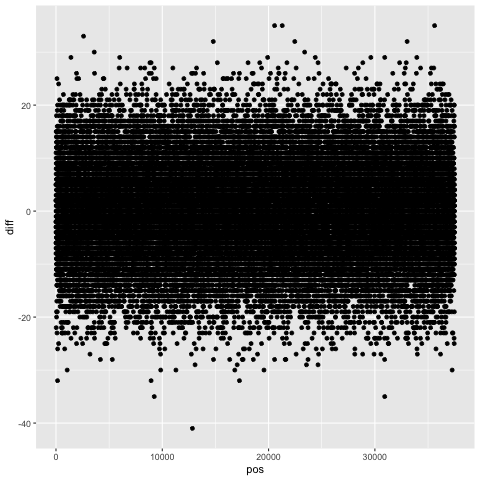

In [128]:
%%R

data.frame(pos = 1:37498,
           depth = rpois(n = 37498, lambda = 37.70846)) %>%
    mutate(depth1 = lead(depth)) %>%
    mutate(diff = depth-depth1) %>%
    #filter(diff < 25, diff > -25) %>%
    ggplot() +
    geom_point(aes(x = pos, y = diff))

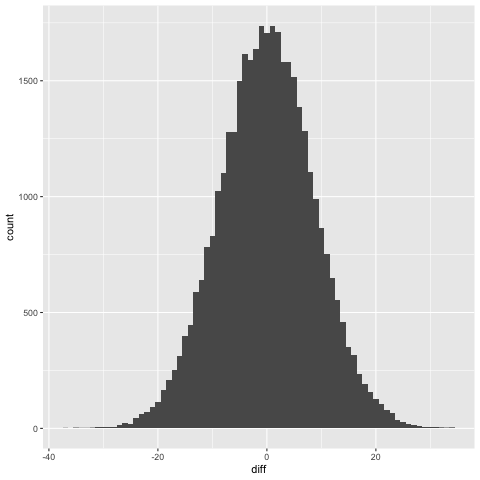

In [242]:
%%R

data.frame(pos = 1:37498,
           depth = rpois(n = 37498, lambda = 37.70846)) %>%
    mutate(depth1 = lead(depth)) %>%
    mutate(diff = depth-depth1) %>%
    ggplot() +
    geom_histogram(aes(x = diff), binwidth = 1)

In [196]:
%%R

data.frame(pos = 1:37498,
           depth = rpois(n = 37498, lambda = 37.70846)) %>%
    mutate(depth1 = lead(depth)) %>%
    mutate(diff = depth-depth1) %>% 
    filter(!is.na(diff)) %>%
    #filter(diff < 25, diff > -25) %>%
    summarize(mean = mean(diff), var = var(diff))

           mean      var
1 -0.0003733632 76.16626


### Linked depth

Same measurments if reads were simulated and the depth per position was calculated from that

In [26]:
seq_len = 37498
n_reads = 9527-12
read_length = 151
df_sim = np.array([int(x) for x in np.random.uniform(low=0.0, high=seq_len, size=n_reads)])
pos = []
for s in df_sim:
    for i in range(s, s+read_length):
        pos.append(i)
pos = np.array(pos)
pos

array([ 3018,  3019,  3020, ..., 20943, 20944, 20945])

In [27]:
df_sim = pd.DataFrame({"pos" : pos})
df_sim

,pos
0,3018
1,3019
2,3020
3,3021
4,3022
...,...
1436760,20941
1436761,20942
1436762,20943
1436763,20944


In [28]:
%R -i df_sim

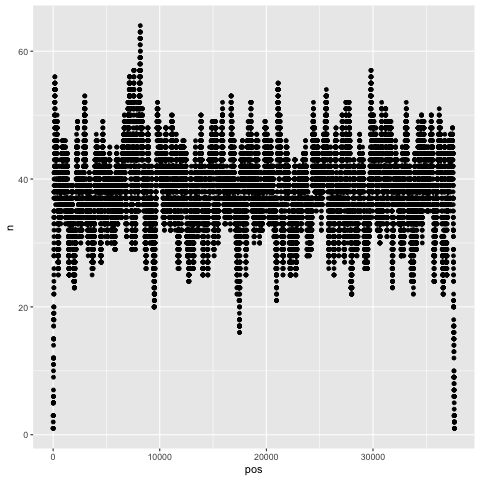

In [29]:
%%R

df_sim %>%
    count(pos) %>% 
    ggplot() +
    geom_point(aes(x = pos, y = n))

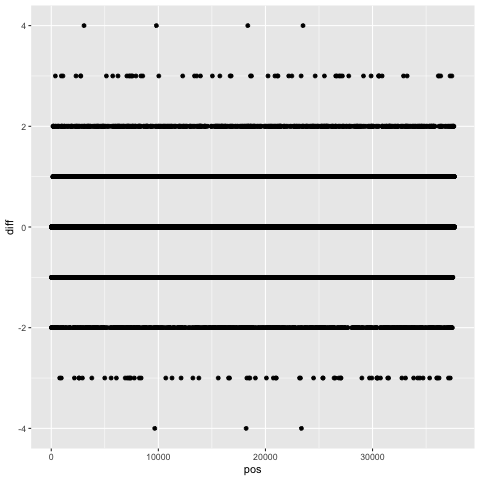

In [30]:
%%R

df_sim %>% 
    count(pos) %>%
    arrange(pos) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    #filter(diff < 25, diff > -25) %>%
    ggplot() +
    geom_point(aes(x = pos, y = diff))

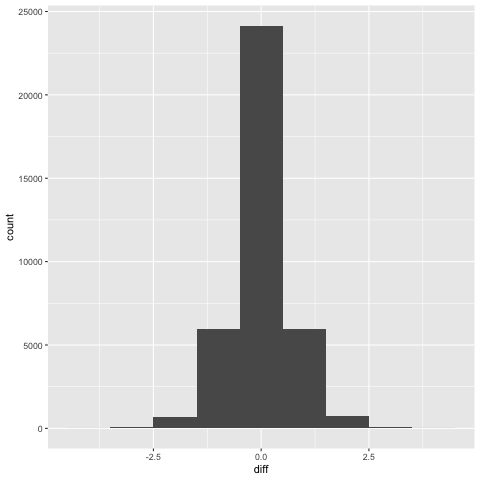

In [31]:
%%R

df_sim %>% 
    count(pos) %>%
    arrange(pos) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    ggplot() +
    geom_histogram(aes(x = diff), binwidth = 1)

In [32]:
%%R

df_sim %>% 
    count(pos) %>%
    arrange(pos) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    filter(!is.na(diff)) %>%
    #filter(diff < 25, diff > -25) %>%
    summarize(mean = mean(diff), var = var(diff))

  mean       var
1    0 0.4994819


### Real data downsampled to match polymorphisms in the human genome

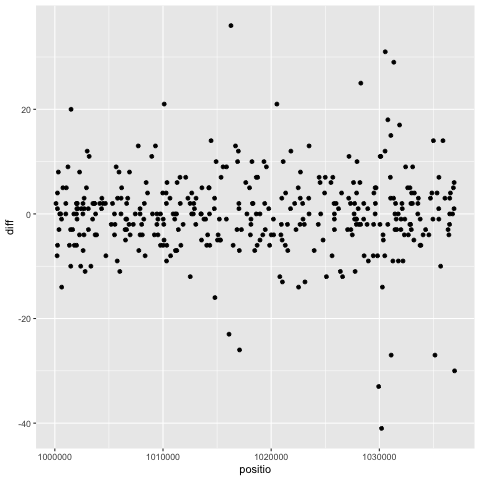

In [220]:
%%R 

df %>%
    count(positio) %>%
    sample_frac(size = 0.01) %>%
    arrange(positio) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    filter(diff < 50, diff > -50) %>%
    ggplot() +
    geom_point(aes(x = positio, y = diff))

In [225]:
%%R 

df %>%
    count(positio) %>%
    sample_frac(size = 0.01) %>%
    arrange(positio) %>%
    mutate(n1 = lead(n)) %>%
    mutate(diff = n-n1) %>%
    filter(diff < 50, diff > -50) %>%
    summarize(mean = mean(diff), var = var(diff))

        mean     var
1 -0.0802139 68.1276


## 10. Error distribution

### 10.1 check real data

You need to run the first 9 chunks or so of the 9.3 section

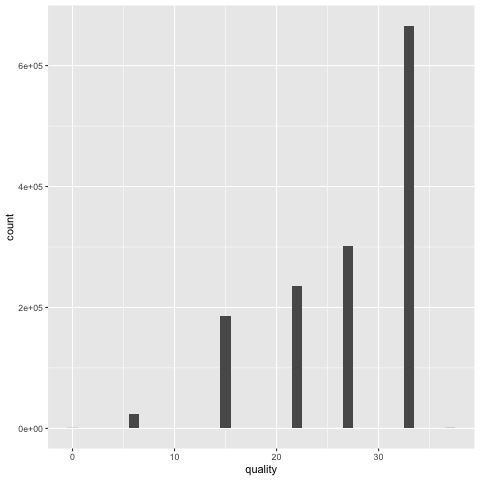

In [30]:
%%R

df %>% 
    ggplot() +
    geom_histogram(aes(x = quality), binwidth = 1)

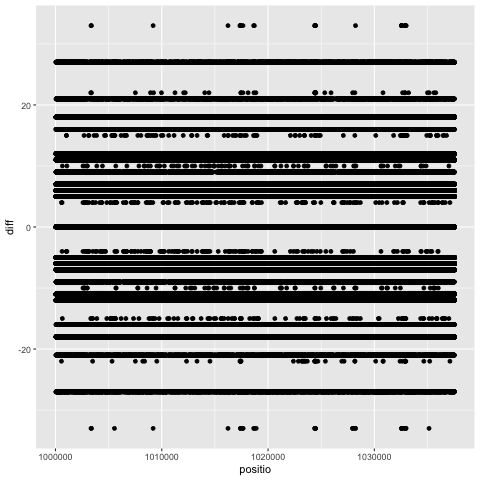

In [53]:
%%R

df %>% 
    group_by(readnum) %>%
    mutate(diff = quality-lead(quality)) %>%
    filter(!is.na(diff)) %>%
    ggplot() +
    geom_point(aes(x = positio, y = diff)) 

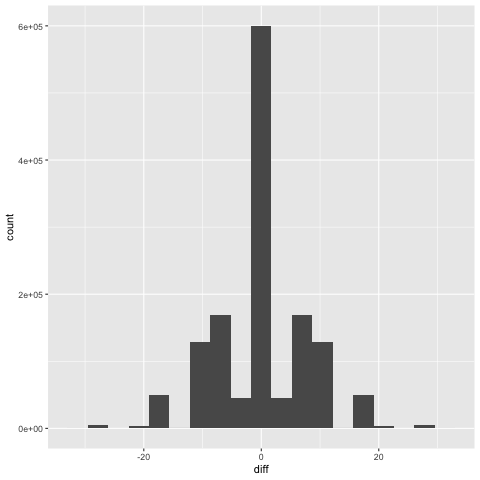

In [54]:
%%R

df %>% 
    group_by(readnum) %>%
    mutate(diff = quality-lead(quality)) %>%
    filter(!is.na(diff)) %>%
    ggplot() +
    geom_histogram(aes(x = diff), bins = 20)

In [56]:
%%R

df %>% 
    group_by(readnum) %>%
    mutate(diff = quality-lead(quality)) %>%
    filter(!is.na(diff)) %>%
    ungroup() %>%
    summarize(mean = mean(diff), var = var(diff))
    

# A tibble: 1 × 2
     mean   var
    <dbl> <dbl>
1 0.00104  63.6


In [16]:
%%R

df$qualityperm <- sample(x = df$quality, replace = FALSE)

df %>% head(20)

     readnum positio quality qualityperm
1960      12 1000050      27          22
1961      12 1000051      22          22
1962      12 1000052      27          22
2106      13 1000050      33          33
2107      13 1000051      22          33
2108      13 1000052      33          27
2109      13 1000053      22          15
2110      13 1000054      27          27
2111      13 1000055      22          33
2112      13 1000056      22          33
2113      13 1000057      27          33
2254      14 1000050      22          33
2255      14 1000051      15          33
2256      14 1000052      27          33
2257      14 1000053      27          33
2258      14 1000054      22          22
2259      14 1000055      33          22
2260      14 1000056      22          27
2261      14 1000057      15          27
2262      14 1000058      27          33


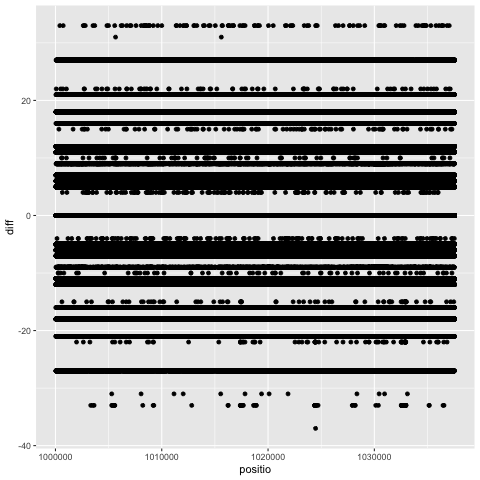

In [18]:
%%R

df %>% 
    mutate(diff = quality-qualityperm) %>%
    ggplot() +
    geom_point(aes(x = positio, y = diff))

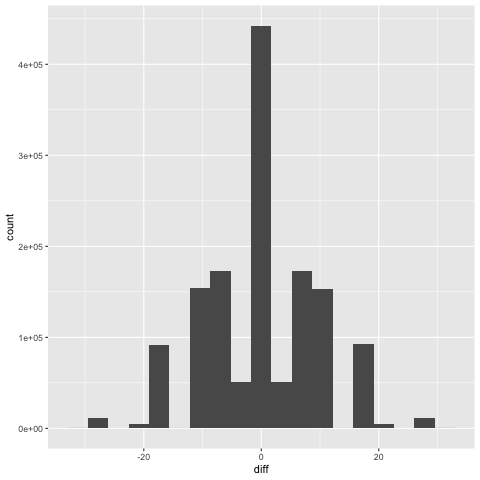

In [12]:
%%R

df %>% 
    mutate(diff = quality-qualityperm) %>%
    ggplot() +
    geom_histogram(aes(x = diff), bins = 20)

In [19]:
%%R

df %>% 
    mutate(diff = quality-qualityperm) %>%
    filter(!is.na(diff)) %>%
    summarize(mean = mean(diff), var = var(diff))

  mean     var
1    0 95.2269


In [37]:
%%R

n = 1000
k = n*0.1
vars <- rep(NULL, n)

for(j in seq(0, n-k, k)){
    print(paste(j*100/n, "%"))
    for(i in seq(j, j+k, 1)){
        vars[i] <- var(df$quality-sample(x = df$quality, replace = FALSE))
    }
}

[1] "0 %"
[1] "10 %"
[1] "20 %"
[1] "30 %"
[1] "40 %"
[1] "50 %"
[1] "60 %"
[1] "70 %"
[1] "80 %"
[1] "90 %"


In [25]:
%%R

var(df$quality-sample(x = df$quality, replace = FALSE))

[1] 94.99819


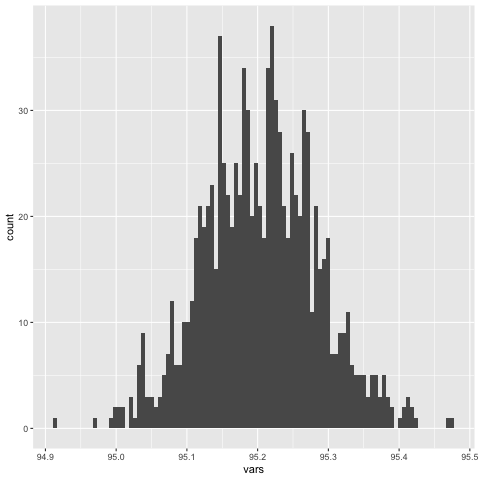

In [43]:
%%R

data.frame(vars = vars) %>%
    ggplot() +
    geom_histogram(aes(x = vars), bins = 100) +
    #geom_vline(xintercept = 63.50372) +
    NULL

In [75]:
%%R

print(100/100)

[1] TRUE


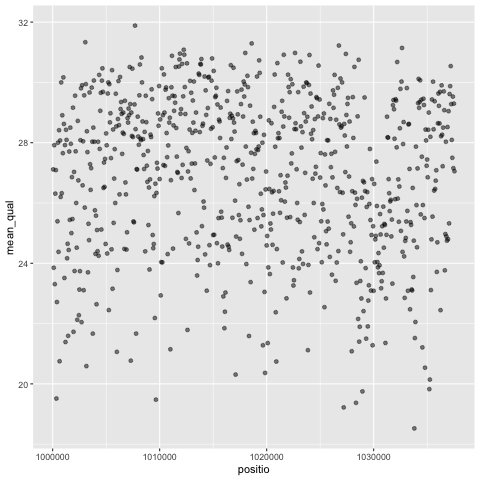

In [82]:
%%R

step = 50
e    = 0.001

df %>%
    group_by(positio) %>%
    summarize(mean_qual = mean(quality)) %>%
    filter(trunc(positio / step) > (positio / step)-e & trunc(positio / step) < (positio / step)+e) %>%
    ggplot() +
    geom_point(aes(x = positio, y = mean_qual), alpha = 0.5)

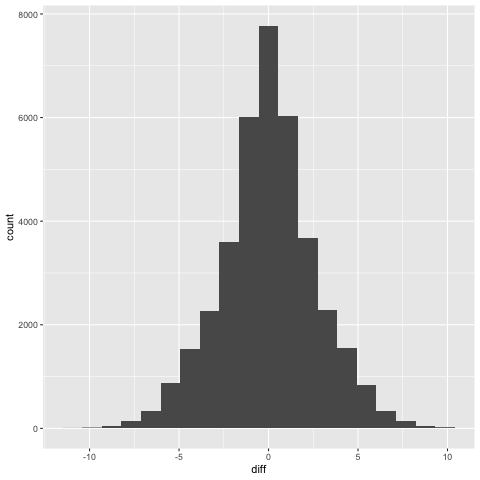

In [83]:
%%R

df %>%
    group_by(positio) %>%
    summarize(mean_qual = mean(quality)) %>%
    #filter(trunc(positio / step) > (positio / step)-e & trunc(positio / step) < (positio / step)+e) %>%
    mutate(diff = mean_qual-lead(mean_qual)) %>%
    filter(!is.na(diff)) %>%
    ggplot() +
    geom_histogram(aes(x = diff), bins = 20)

In [89]:
%%R

df %>%
    group_by(positio) %>%
    summarize(mean_qual = mean(quality)) %>%
    #filter(trunc(positio / step) > (positio / step)-e & trunc(positio / step) < (positio / step)+e) %>%
    mutate(diff = mean_qual-lead(mean_qual)) %>%
    filter(!is.na(diff)) %>%
    summarize(mean_diff = mean(diff), var_diff = var(diff))

# A tibble: 1 × 2
   mean_diff var_diff
       <dbl>    <dbl>
1 0.00000165     6.97


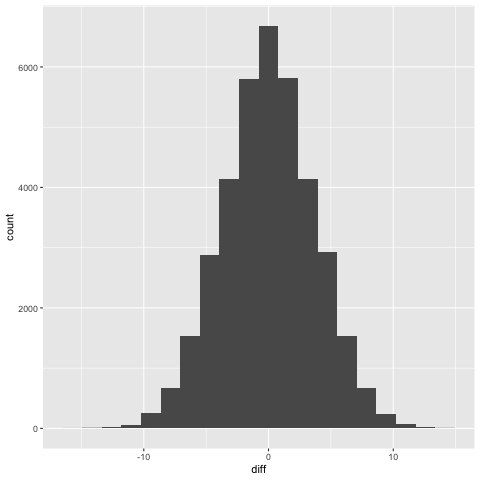

In [88]:
%%R

df %>%
    group_by(positio) %>%
    summarize(mean_qual = mean(quality)) -> mean_df

mean_df %>%
    pull(mean_qual) -> mean_qual_vec

mean_df$perm_mean_qual <- sample(x = mean_qual_vec, replace = FALSE)

mean_df %>% 
    mutate(diff = mean_qual-perm_mean_qual) %>%
    ggplot() +
    geom_histogram(aes(x = diff), bins = 20)

In [90]:
%%R

mean_df %>% 
    mutate(diff = mean_qual-perm_mean_qual) %>%
    summarize(mean_diff = mean(diff), var_diff = var(diff))

# A tibble: 1 × 2
  mean_diff var_diff
      <dbl>    <dbl>
1         0     13.5


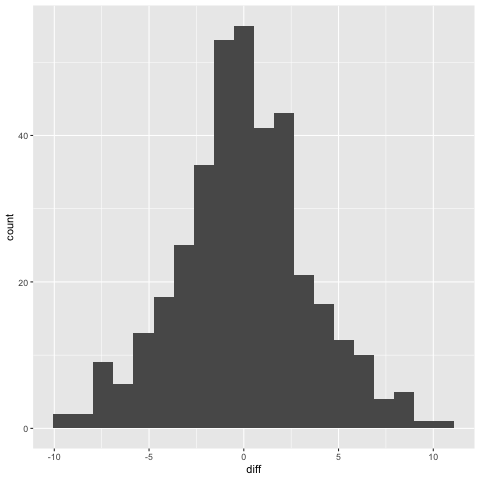

In [93]:
%%R


step = 100
e    = 0.001

df %>%
    group_by(positio) %>%
    summarize(mean_qual = mean(quality)) %>%
    filter(trunc(positio / step) > (positio / step)-e & trunc(positio / step) < (positio / step)+e) %>%
    mutate(diff = mean_qual-lead(mean_qual)) %>%
    filter(!is.na(diff)) %>%
    ggplot() +
    geom_histogram(aes(x = diff), bins = 20)

In [94]:
%%R

step = 100
e    = 0.001

df %>%
    group_by(positio) %>%
    summarize(mean_qual = mean(quality)) %>%
    filter(trunc(positio / step) > (positio / step)-e & trunc(positio / step) < (positio / step)+e) %>%
    mutate(diff = mean_qual-lead(mean_qual)) %>%
    filter(!is.na(diff)) %>%
    summarize(mean_diff = mean(diff), var_diff = var(diff))

# A tibble: 1 × 2
  mean_diff var_diff
      <dbl>    <dbl>
1   -0.0146     12.0


### Distributions of bp quality simulating as independent

To obtain such distributions I run `fastqc` on the fastq file that I downloaded from the HGDP

```
fastqc --nogroup ERR757817_1.fastq.gz
```

This outputs a `ERR757817_1_fastqc.zip` file, that after unziping it with the command

```
unzip ERR757817_1_fastqc.zip
```

Outputs a directory. In it, we can find the file

```
ls ERR757817_1_fastqc/fastqc_data.txt
```

which contains the counts of bases in all the reads with a certain bp quality

In [11]:
%%bash

head /Users/au552345/Desktop/fastqc_data.txt

##FastQC	0.11.9
>>Basic Statistics	pass
#Measure	Value
Filename	ERR757817_1.fastq.gz
File type	Conventional base calls
Encoding	Sanger / Illumina 1.9
Total Sequences	355682661
Sequences flagged as poor quality	0
Sequence length	151
%GC	43


In [8]:
def read_fastqc_data(file):
    quals  = []
    counts = []

    printing = False
    with open(file, "r") as file:
        for line in file:
            if ">>END_MODULE" in line and printing:
                break
            if printing:
                if "#" not in line:  
                    qual, count = line.strip().split()
                    quals.append(int(qual))
                    counts.append(int(float(count)))

            if ">>Per sequence quality scores" in line:
                printing = True

    qualsdist = pd.DataFrame({"quality" : quals,
                              "counts"  : counts})
    return qualsdist

qualsdist = read_fastqc_data("/Users/au552345/GenomeDK/fastqsbams/ERR757817_1_fastqc/fastqc_data.txt")

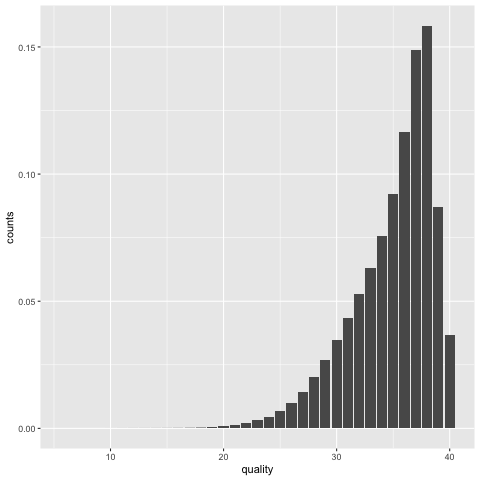

In [9]:
%%R -i qualsdist

qualsdist %>%
    mutate(counts = counts/sum(counts)) %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = quality, y = counts)) -> HGDP_plot
    
HGDP_plot

In [11]:
qualsdist2 = read_fastqc_data("/Users/au552345/GenomeDK/fastqsbams/HGDP00001.cram2fastq_fastqc/fastqc_data.txt")

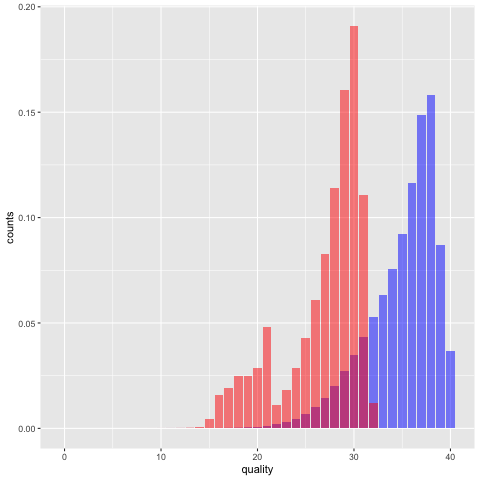

In [19]:
%%R -i qualsdist2 -i qualsdist

qualsdist %>%
    mutate(counts = counts/sum(counts)) %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = quality, y = counts), alpha = 0.5, fill = "blue") +
    geom_bar(data = qualsdist2, stat = "identity", aes(x = quality, y = counts/sum(counts)), alpha = 0.5, fill = "red")

I downloaded some other fastq files:

- Young Yana

```
wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR335/001/ERR3351001/ERR3351001.fastq.gz
```

- Ust'Ishim

```
wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR566/ERR566093/ERR566093_1.fastq.gz
```

- Sunghir I

```
wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR211/004/ERR2117984/ERR2117984.fastq.gz
```

In [14]:
qualsdist = read_fastqc_data("/Users/au552345/GenomeDK/fastqsbams/ERR566093_1_fastqc/fastqc_data.txt")

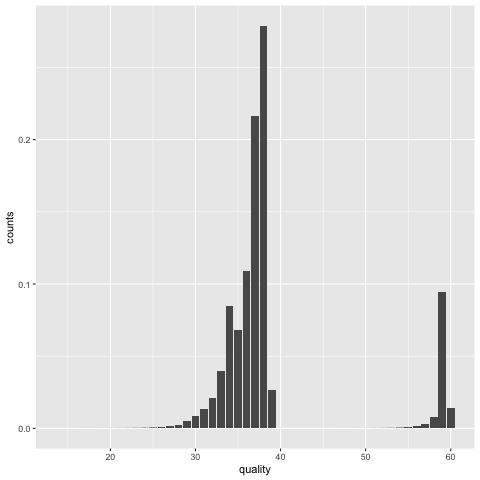

In [15]:
%%R -i qualsdist

qualsdist %>%
    mutate(counts = counts/sum(counts)) %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = quality, y = counts)) -> UST_plot
    
UST_plot

In [16]:
qualsdist = read_fastqc_data("/Users/au552345/GenomeDK/fastqsbams/ERR3351001_fastqc/fastqc_data.txt")

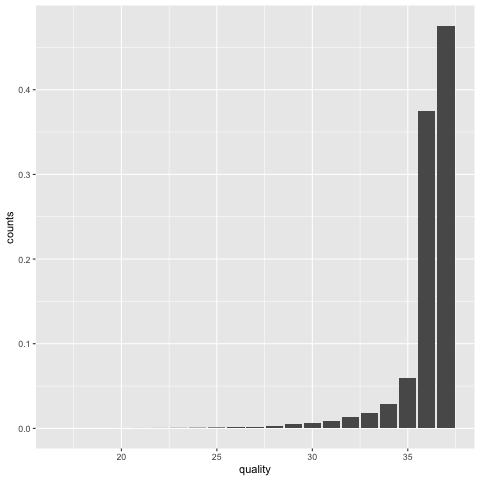

In [17]:
%%R -i qualsdist

qualsdist %>%
    mutate(counts = counts/sum(counts)) %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = quality, y = counts)) -> YAN_plot
    
YAN_plot

In [18]:
qualsdist = read_fastqc_data("/Users/au552345/GenomeDK/fastqsbams/ERR2117984_fastqc/fastqc_data.txt")

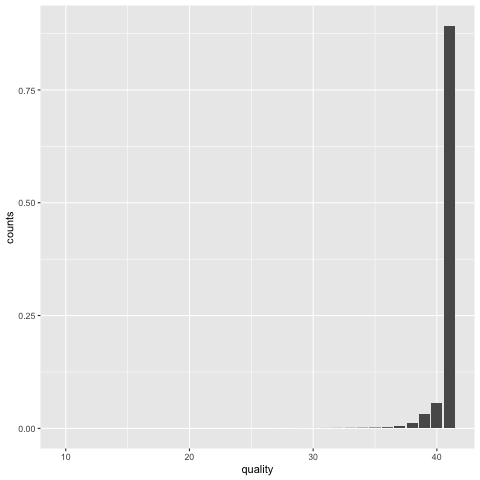

In [19]:
%%R -i qualsdist

qualsdist %>%
    mutate(counts = counts/sum(counts)) %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = quality, y = counts)) -> SUN_plot
    
SUN_plot

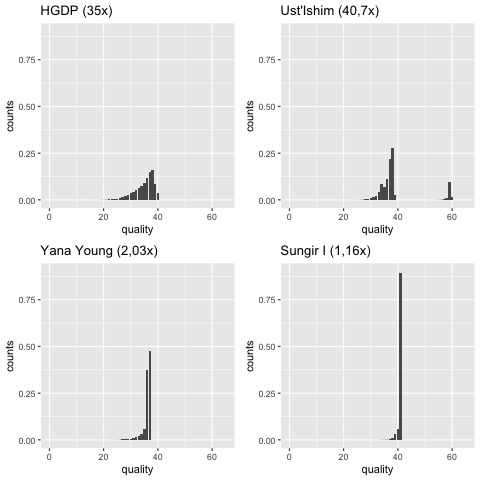

In [27]:
%%R

plot_grid(HGDP_plot + xlim(c(0, 65)) + ylim(0, 0.9) + ggtitle("HGDP (35x)"), 
          UST_plot  + xlim(c(0, 65)) + ylim(0, 0.9) + ggtitle("Ust'Ishim (40,7x)"),
          YAN_plot  + xlim(c(0, 65)) + ylim(0, 0.9) + ggtitle("Yana Young (2,03x)"),
          SUN_plot  + xlim(c(0, 65)) + ylim(0, 0.9) + ggtitle("Sungir I (1,16x)"))

In [25]:
seed = 1234
rng  = np.random.default_rng(seed)
gm   = np.array([[0, 0, 1, 0], 
                 [1, 1, 0, 1]])
ref  = np.array(["A", "C"])
alt  = np.array(["C", "T"])

In [68]:
def depth_per_haplotype(rng, mean_depth, std_depth, n_hap):
    if isinstance(mean_depth, np.ndarray):
        return mean_depth
    else:
        dp = np.full((n_hap, ), 0.0)
        while (dp <= 0).sum():
            n = (dp <= 0).sum()
            dp[dp <= 0] = rng.normal(loc = mean_depth, scale = std_depth, size=n)
        return dp

mean_depth = 15
std_depth  = 2
DPh        = np.array([15, 20, 45, 65])
DP         = rng.poisson(DPh, size=gm.shape)
print("DPh")
print(DPh)
print("DP")
print(DP)

DPh
[15 20 45 65]
DP
[[14 31 44 75]
 [22 19 30 68]]


In [115]:
e   = np.array([0.05, 0.05, 0.01, 0.01])
#e   = 0.05
err = np.array([[1-e, e/3, e/3, e/3], [e/3, 1-e, e/3, e/3], [e/3, e/3, 1-e, e/3], [e/3, e/3, e/3, 1-e]])

In [116]:
a = 0.0


In [117]:
if type(e) != type(float):
    err = err.transpose(2, 0, 1)
print(err.shape)
err

(4, 4, 4)


array([[[0.95      , 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.95      , 0.01666667, 0.01666667],
        [0.01666667, 0.01666667, 0.95      , 0.01666667],
        [0.01666667, 0.01666667, 0.01666667, 0.95      ]],

       [[0.95      , 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.95      , 0.01666667, 0.01666667],
        [0.01666667, 0.01666667, 0.95      , 0.01666667],
        [0.01666667, 0.01666667, 0.01666667, 0.95      ]],

       [[0.99      , 0.00333333, 0.00333333, 0.00333333],
        [0.00333333, 0.99      , 0.00333333, 0.00333333],
        [0.00333333, 0.00333333, 0.99      , 0.00333333],
        [0.00333333, 0.00333333, 0.00333333, 0.99      ]],

       [[0.99      , 0.00333333, 0.00333333, 0.00333333],
        [0.00333333, 0.99      , 0.00333333, 0.00333333],
        [0.00333333, 0.00333333, 0.99      , 0.00333333],
        [0.00333333, 0.00333333, 0.00333333, 0.99      ]]])

In [118]:
def refalt_int_encoding(gm, ref, alt):
    refalt_str                    = np.array([ref, alt])
    refalt_int                    = np.zeros(refalt_str.shape, dtype=int)
    refalt_int[refalt_str == "C"] = 1
    refalt_int[refalt_str == "G"] = 2
    refalt_int[refalt_str == "T"] = 3
    return refalt_int[gm.reshape(-1), np.repeat(np.arange(gm.shape[0]), gm.shape[1])].reshape(gm.shape)


gmbp = refalt_int_encoding(gm, ref, alt)
print(gmbp)
print(gmbp.reshape(-1))

[[0 0 1 0]
 [3 3 1 3]]
[0 0 1 0 3 3 1 3]


In [119]:
np.tile(np.arange(gmbp.shape[1]), gmbp.shape[0])

array([0, 1, 2, 3, 0, 1, 2, 3])

In [120]:
gmbp.reshape(-1)

array([0, 0, 1, 0, 3, 3, 1, 3])

In [121]:
gmbp.reshape(-1)

array([0, 0, 1, 0, 3, 3, 1, 3])

In [122]:
type(e) == float

False

In [124]:
DP

array([[14, 31, 44, 75],
       [22, 19, 30, 68]])

In [123]:
if type(e) == float:
    arc = rng.multinomial(DP, err[gmbp])
else:
    arc = rng.multinomial(DP, err[np.tile(np.arange(gmbp.shape[1]), gmbp.shape[0]), gmbp.reshape(-1)].reshape(gmbp.shape[0], gmbp.shape[1], 4))
print(arc)

[[[12  0  1  1]
  [31  0  0  0]
  [ 0 44  0  0]
  [75  0  0  0]]

 [[ 0  2  0 20]
  [ 0  0  1 18]
  [ 0 30  0  0]
  [ 1  0  0 67]]]


In [57]:
err[[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1, 1], [0, 1, 2, 3, 0, 1, 2, 3]]

array([0.95, 0.95, 0.99, 0.99, 0.95, 0.95, 0.99, 0.99])

In [21]:
gmbp

array([[0, 0, 1, 0],
       [3, 3, 1, 3]])

In [16]:
refalt_str = np.array([ref, alt])
refalt_str

array([['A', 'C'],
       ['C', 'A']], dtype='<U1')

In [19]:
refalt_int = np.zeros(np.array([ref, alt]).shape, dtype=int)
print(refalt_int)
refalt_int[refalt_str == "C"] = 1
refalt_int[refalt_str == "G"] = 2
refalt_int[refalt_str == "T"] = 3
print(refalt_int)

[[0 0]
 [0 0]]
[[0 1]
 [1 0]]


In [263]:
import numpy as np
from itertools import combinations_with_replacement
from itertools import combinations
from scipy.stats import binom

def e2q(e):
    return -10*np.log(e)

def q2e(q):
    return np.exp(-q/10)

def incorporate_monomorphic(gm, pos, start, end):
    '''
    Incorporates monomorphic sites in a polymorphic genotype matrix.

    Parameters
    ----------
    gm  : `numpy.ndarray` 
        Genotype matrix with size (polymorphic sites, haplotypic samples) in which 0 denotes reference allele
        and 1 denotes alternative allele.
    pos : `numpy.ndarray` 
        Genomic coordinates of the polymorphic sites with size (polymorphic sites, ) as integer or float values >= 0.
        If floats are provided, the decimal values will be truncated (e.g., 1.8 -> 1). The values must be sorted and the 
        order of these values must be the same as the first dimetion of `gm`.
    start : `int` or `float`
        Genomic start coordinate of the range for which monomorphic sites will be incorporated in the original
        `gm` matrix. The value must be >= 0 <= min(pos). If floats are provided, the decimal values will be 
        truncated (e.g., 1.8 -> 1).
    end : `int`
        Genomic end coordinate of the range for which monomorphic sites will be incorporated in the original
        `gm` matrix. The value must be >= max(pos). If floats are provided, the decimal values will be 
        truncated (e.g., 1.8 -> 1).
    
    Returns 
    -------
    gm2 : `numpy.ndarray`
        Genotype matrix with size (end-start, haplotypic samples) in which 0 denotes reference allele
        and 1 denotes alternative allele.
    '''
    assert check_gm(gm) and check_pos(gm, pos) and check_start(pos, start) and check_end(pos, end)
    gm2 = np.zeros((int(end)-int(start), gm.shape[1]))
    gm2[pos.astype(int)] = gm
    return gm2

def refalt(ref, alt, n_sit):
    if ref is None and alt is None:
        ref = np.full(n_sit, "A")
        alt = np.full(n_sit, "C")
    return ref, alt

def depth_per_haplotype(rng, mean_depth, std_depth, n_hap):
    if isinstance(mean_depth, np.ndarray):
        return mean_depth
    else:
        dp = np.full((n_hap, ), 0.0)
        while (dp <= 0).sum():
            n = (dp <= 0).sum()
            dp[dp <= 0] = rng.normal(loc = mean_depth, scale = std_depth, size=n)
        return dp

def refalt_int_encoding(gm, ref, alt):
    refalt_str                    = np.array([ref, alt])
    refalt_int                    = np.zeros(refalt_str.shape, dtype=int)
    refalt_int[refalt_str == "C"] = 1
    refalt_int[refalt_str == "G"] = 2
    refalt_int[refalt_str == "T"] = 3
    return refalt_int[gm.reshape(-1), np.repeat(np.arange(gm.shape[0]), gm.shape[1])].reshape(gm.shape)

def linked_depth(rng, DPh, read_length, sites_n):
    '''
    Simulates reads in a contiguous genomic region to compute the depth per position.
    
    Parameters
    ----------
    rng : `numpy.random._generator.Generator` 
        random number generation numpy object
    DPh : `numpy.ndarray`
        Numpy array with the depth per haplotype
    read_length : `int`
        Read length in base pair units
    sites_n : `int`
        number of sites that depth has to be simulated for
    
    Returns 
    -------
    DP : `numpy.ndarray`
        Depth per site per haplotype
    '''
    DP = []
    read_n     = ((DPh*sites_n)/read_length).astype("int")
    for r in read_n:
        dp = np.zeros((sites_n,), dtype=int)
        for p in rng.integers(low=0, high=sites_n-read_length+1, size=r):
            dp[p:p+read_length] += 1
        DP.append(dp.tolist())
    return np.array(DP).T

def independent_depth(rng, DPh, size):
    '''
    Returns depth per position per haplotype (size[0], size[1]) drawn from the "rng" from a Poisson 
    distribution with a lambda value "DPh" per haplotype
    '''
    return rng.poisson(DPh, size=size)

def depth_per_site_per_haplotype(rng, depth_type, DPh, gm_shape, read_length): 
    if depth_type == "independent":
        DP  = independent_depth(rng, DPh, gm_shape)
    elif depth_type == "linked":
        assert check_positive_nonzero_integer(read_length, "read_length")
        DP  = linked_depth(rng, DPh, read_length, gm_shape[0])
    assert DP.shape == gm_shape
    return DP

def simulate_arc(e, err, rng, DP, gmbp):
    if isinstance(e, np.ndarray):
        err = err.transpose(2, 0, 1)
        return rng.multinomial(DP, err[np.tile(np.arange(gmbp.shape[1]), gmbp.shape[0]), gmbp.reshape(-1)].reshape(gmbp.shape[0], gmbp.shape[1], 4))
    else:
        return rng.multinomial(DP, err[gmbp])

def sim_allelereadcounts(gm, mean_depth, e, ploidy, seed = None, std_depth = None, ref = None, alt = None, read_length = None, depth_type = "independent"):
    '''
    Simulates allele read counts from a genotype matrix. 
    
    Parameters
    ----------
    gm : `numpy.ndarray` 
        Genotype matrix with size (sites, haplotypic samples) in which 0 denotes reference allele
        and 1 denotes alternative allele.
    
    mean_depth : `int` or `float` or `numpy.ndarray`
        Read depth of the each haplotypic sample in `gm`. If a `int` or `float` value is inputed, the function
        will sample random values from a normal distribution with mean = `mean_depth` and std = `std_depth`.
        If a `numpy.ndarray` is inputed, there must be an error value per haplotype (i.e., the array must have size 
        (haplotypic samples, )) and the order must be the same as the second dimention of `gm`.
    
    std_depth : `int` or `float`
        The standard deviation parameter of the normal distribution from which read depth values are randomly
        sampled for each haplotypic sample in `gm`. This value only needs to be provided if the `mean_depth`
        inputed is an `int` or a `float`.
    
    e : `int` or `float` or `numpy.ndarray`
        Sequencing error probability per base pair per site. The values must be between 0 and 1. If a `int` or `float` 
        value is inputed, the function will use the same error probablity value for each haplotype and each site. 
        If a `numpy.ndarray` is inputed, there must be an error value per haplotype (i.e., the array must have size 
        (haplotypic samples, )) and the order must be the same as the second dimention of `gm`.
    
    ploidy : `int` 
        Number of haplotypic chromosomes per individual.
    
    ref : `numpy.ndarray`, optional
        Reference alleles list per site. The size of the array must be (sites, ) and the order has to 
        coincide with the first dimetion of `gm`. The values within the list must be strings {"A", "C", 
        "G", "T"}. If an `alt` list is inputed, a `ref` list must also be inputed. If no `ref` and `alt`
        are inputed, the `ref` allele is assumed to be "A" for all sites.
    
    alt : `numpy.ndarray`, optional
        Alternative alleles list per site. The size of the array must be (sites, ) and the order has to 
        coincide with the first dimetion of `gm`. The values within the list must be strings {"A", "C", 
        "G", "T"}. If a `ref` list is inputed, an `alt` list must also be inputed. If no `ref` and `alt`
        are inputed, the `alt` allele is assumed to be "C" for all sites.

    seed : `int`, optional
        Starting point in generating random numbers.
    
    Returns 
    -------
    arc : `numpy.ndarray`
        Allele read counts per site per individual. The dimentions of the array are (sites, individuals, alleles). 
        The third dimention of the array has size = 4, which corresponds to the four possible alleles: 0 = "A", 
        1 = "C", 2 = "G" and 3 = "T".
    
    Notes
    -----
    - The read depth indicated in `mean_depth` is per haplotypic sample, i.e. if the user intends to simulate a 
      depth of 30 reads per site per individual, and individuals are diploid (`ploidy` = 2), the `mean_depth` 
      must be 15. 
    - If monomorphic sites are included, the `alt` values corresponding to those sites are not taken into account, 
      but they must be still indicated.
    '''
    #Checks
    assert check_gm(gm)
    ref, alt = refalt(ref, alt, gm.shape[0])
    assert check_mean_depth(gm, mean_depth) and check_std_depth(mean_depth, std_depth) and check_e(gm, e) and check_ploidy(ploidy) and check_gm_ploidy(gm, ploidy) and check_ref_alt(gm, ref, alt) and check_depth_type(depth_type)
    #Variables
    err = np.array([[1-e, e/3, e/3, e/3], [e/3, 1-e, e/3, e/3], [e/3, e/3, 1-e, e/3], [e/3, e/3, e/3, 1-e]])
    rng = np.random.default_rng(seed)
    #1. Depths (DP) per haplotype (h)
    DPh = depth_per_haplotype(rng, mean_depth, std_depth, gm.shape[1])
    print("DPh")
    print(DPh)
    #2. Sample depths (DP) per site per haplotype
    DP = depth_per_site_per_haplotype(rng, depth_type, DPh, gm.shape, read_length)
    print("DP")
    print(DP)
    #3. Sample correct and error reads per SNP per haplotype (Rh)
    #3.1. Convert anc = 0/der = 1 encoded gm into "A" = 0, "C" = 1, "G" = 3, "T" = 4 basepair (bp) encoded gm 
    gmbp = refalt_int_encoding(gm, ref, alt)
    #3.2. Simulate allele read counts (ARC) per haplotype (h) per site (s)
    arc = simulate_arc(e, err, rng, DP, gmbp)
    #4. Add n haplotype read allele counts (n = ploidy) to obtain read allele counts per genotype
    return arc.reshape(arc.shape[0], arc.shape[1]//ploidy, ploidy, arc.shape[2]).sum(axis = 2)

def get_GTxploidy(ploidy):
    return np.array([list(x) for x in combinations_with_replacement([0, 1, 2, 3], ploidy)])

def allelereadcounts_to_GL(arc, e, ploidy):
    '''
    Computes genotype likelihoods from allele read counts per site per individual. 
    
    Parameters
    ----------
    arc : `numpy.ndarray`
        Allele read counts per site per individual. The dimentions of the array are (sites, individuals, alleles). 
        The third dimention of the array has size = 4, which corresponds to the four possible alleles: 0 = "A", 
        1 = "C", 2 = "G" and 3 = "T".
    
    e : `float` 
        Sequencing error probability per base pair per site. The value must be between 0 and 1.

    ploidy : `int` 
        Number of haplotypic chromosomes per individual.  

    Returns 
    -------

    GL : `numpy.ndarray`
        Normalized genotype likelihoods per site per individual. The dimentions of the array are (sites, individuals, genotypes). 
        The third dimention of the array corresponds to the combinations with replacement of all 4 possible alleles 
        {"A", "C", "G", "T"} (i.e., for a diploid, there are 10 possible genotypes and the combination order is "AA", "AC",
        "AG", "AT", "CC", "CG", ..., "TT"). 

    References
    ----------
    1) McKenna A, Hanna M, Banks E, Sivachenko A, Cibulskis K, Kernytsky A, Garimella K, Altshuler D, Gabriel S, Daly M, DePristo MA (2010). The Genome Analysis Toolkit: a MapReduce framework for analyzing next-generation DNA sequencing data. Genome Res. 20:1297-303.
    2) Thorfinn Sand Korneliussen, Anders Albrechtsen, Rasmus Nielsen. ANGSD: Analysis of Next Generation Sequencing Data. BMC Bioinform. 2014 Nov;15,356.
    '''
    #assert check_arc(arc) and check_e(e) and check_ploidy(ploidy)
    
    GTxploidy    = get_GTxploidy(ploidy)
    AFxGTxploidy = np.array([(GTxploidy == 0).sum(axis = 1), (GTxploidy == 1).sum(axis = 1), (GTxploidy == 2).sum(axis = 1), (GTxploidy == 3).sum(axis = 1)])/ploidy
    
    GL = np.multiply(-np.log(AFxGTxploidy*(1-e)+(1-AFxGTxploidy)*(e/3)), arc.reshape(arc.shape[0], arc.shape[1], arc.shape[2], 1)).sum(axis = 2)
    return GL-GL.min(axis = 2).reshape(GL.shape[0], GL.shape[1], 1)
    
def get_pGTxMm(ploidy):
    GTxploidy    = np.array([list(x) for x in combinations_with_replacement([0, 1, 2, 3], ploidy)])
    Mmxploidy    = np.array([list(x) for x in combinations([0, 1, 2, 3], 2)])
    pGTxMm = []
    #For every genotype (GT)
    for i in range(GTxploidy.shape[0]):
        pGTxMm_tmp = []
        #For every combination of major (M) and minor (m) alleles (M and m can't be the same allele and there can be only two)
        for j in range(Mmxploidy.shape[0]):
            #All alleles in GT are either M or m
            all_GT_in_Mm = (np.isin(GTxploidy[i],  Mmxploidy[j]).sum() == ploidy)*1
            #Probability of the genotype given M and m only possible alleles
            p_GT = binom.pmf((GTxploidy[i] == Mmxploidy[j, 0]).sum(), ploidy, 0.5)
            pGTxMm_tmp.append( p_GT * all_GT_in_Mm )
        pGTxMm.append(np.array(pGTxMm_tmp))
    return np.array(pGTxMm)

def GL_to_Mm(GL, ploidy):
    '''
    Computes maximum (M) and minimum (m) frequency alleles in the population from genotype likelihoods. 
    
    Parameters
    ----------
    GL : `numpy.ndarray`
        Normalized genotype likelihoods per site per individual. The dimentions of the array is (sites, individuals, genotypes). 
        The third dimention of the array corresponds to the combinations with replacement of all 4 possible alleles 
        {"A", "C", "G", "T"} (i.e., for a diploid, there are 10 possible genotypes and the combination order is "AA", "AC",
        "AG", "AT", "CC", "CG", ..., "TT"). 

    ploidy : `int` 
        Number of haplotypic chromosomes per individual. 

    Returns 
    -------
    `numpy.ndarray`
        Maximum and minimum alleles per site. The dimentions of the array is (sites, ) and the values per site is an integer 
        encoding the pair of M and m: 0 = "AC", 1 = "AG", 2 = "AT", 3 = "CG", 4 = "CT", 5 = "GT".
    
    References
    ----------
    1) Line Skotte, Thorfinn Sand Korneliussen, Anders Albrechtsen. Association testing for next-generation sequencing data using score statistics. Genet Epidemiol. 2012 Jul;36(5):430-7.
    2) Thorfinn Sand Korneliussen, Anders Albrechtsen, Rasmus Nielsen. ANGSD: Analysis of Next Generation Sequencing Data. BMC Bioinform. 2014 Nov;15,356.
    '''
    #TO DO: when there are too many individuals, the numeric operation is not sable.
    assert check_ploidy(ploidy) and check_GL(GL, ploidy)
    pGTxMm = get_pGTxMm(ploidy)
    return np.argmin((GL.reshape(GL.shape[0], GL.shape[1], GL.shape[2], 1) * pGTxMm.reshape(1, 1, pGTxMm.shape[0], pGTxMm.shape[1])).sum(axis = 2).prod(axis = 1), axis = 1)

def allelereadcounts_to_pileup(arc, output):
    '''
    Writes an allele read counts in a file in pileup format.

    Parameters
    ----------
    arc : `numpy.ndarray`
        Allele read counts per site per individual. The dimentions of the array are (sites, individuals, alleles). 
        The third dimention of the array has size = 4, which corresponds to the four possible alleles: 0 = "A", 
        1 = "C", 2 = "G" and 3 = "T".
    
    output : `str`
        Output file name.

    Returns 
    -------
    None
    '''
    if not (isinstance(arc, np.ndarray) and len(arc.shape) == 3 and arc.shape[2] == 4):
        raise TypeError('Incorrect `arc` format: it has to be a numpy array with dimentions (sites, individuals, alleles) and the third dimention must be of size = 4')
    if not (isinstance(output, str)):
        raise TypeError('Incorrect `output` format: it has to be a string with the path where the output is written')
    with open(output, "w") as out:
        for i in range(arc.shape[0]):
            line = "1\t"+str(i+1)+"\tN"
            for j in range(arc.shape[1]):
                nreads = arc[i, j, :].sum()
                line = line+"\t"+str(nreads)+"\t"
                if nreads:
                    for c, b in zip(arc[i, j, :], ["A", "C", "G", "T"]):
                        line = line+c*b
                    line = line+"\t"+"."*nreads
                else:
                    line = line+"\t*\t*"
            out.write(line+"\n")

# Functions to check input formatting
def check_gm(gm):
    if not (isinstance(gm, np.ndarray) and len(gm.shape) == 2 and ((gm == 0)+(gm == 1)).sum() == gm.size):
        raise TypeError('Incorrect gm format: it has to be a numpy array with dimentions (sites, haplotypic samples) with integer values 1 and 0')
    return True

def check_mean_depth(gm, mean_depth):
    if not ((isinstance(mean_depth, np.ndarray) and len(mean_depth.shape) == 1 and mean_depth.shape[0] == gm.shape[1] and (mean_depth > 0).sum() == mean_depth.size) or (isinstance(mean_depth, (int, float)) and mean_depth > 0.0)):
        raise TypeError('Incorrect mean_depth format: it has to be either i) numpy.array with dimentions (haplotypic samples, ) with values > 0 or ii) integer or float value > 0')
    return True

def check_std_depth(mean_depth, std_depth):
    if not ((isinstance(mean_depth, np.ndarray)) or (isinstance(std_depth, (int, float)) and std_depth >= 0.0)):
        raise TypeError('Incorrect std_depth format: it has to be an integer or float value > 0 if mean_depth is a integer or float value and not a numpy array')
    return True

def check_e(gm, e):
    if not ((isinstance(e, np.ndarray) and len(e.shape) == 1 and e.shape[0] == gm.shape[1] and ((e >= 0)*(e <= 1)).sum() == e.size) or (isinstance(e, (int, float)) and e >= 0.0 and e <= 1.0)):
        raise TypeError('Incorrect e format: it has to be either i) numpy.array with dimentions (haplotypic samples, ) with values 0 <= e <= 1 or ii) integer or float value 0 <= e <= 1')
    return True

def check_ploidy(ploidy):
    if not (isinstance(ploidy, int) and ploidy > 0) :
        raise TypeError('Incorrect ploidy format: it has to be an integer value > 0')
    return True

def check_gm_ploidy(gm, ploidy):
    if not (gm.shape[1]%ploidy == 0) :
        raise TypeError('Incorrect ploidy and/or gm format: the second dimention of gm (haplotypic samples) must be divisible by ploidy')
    return True

def check_depth_type(depth_type):
    if not isinstance(depth_type, str) and depth_type not in ["independent", "linked"]:
        raise TypeError('Incorrect depth_type format: it has to be a string, either "independent" or "linked"')
    return True

def check_positive_nonzero_integer(read_length, name):
    if not isinstance(read_length, int) and read_length <= 0:
        raise TypeError('Incorrect {} format: it has to be a integer value > 0'.format(name))
    return True

def check_ref_alt(gm, ref, alt):
    if not (isinstance(ref, np.ndarray) and isinstance(alt, np.ndarray) and len(ref.shape) == 1 and len(alt.shape) == 1 and ref.shape == alt.shape and ref.size == gm.shape[0] and
              ((ref == "A") + (ref == "C") + (ref == "G") + (ref == "T")).sum() == ref.size and ((alt == "A") + (alt == "C") + (alt == "G") + (alt == "T")).sum() == alt.size):
        raise TypeError('Incorrect ref and/or alt format: they both have to be a numpy array with dimentions (sites, ) with string "A", "C", "G", "T" values')
    return True

def check_pos(gm, pos):
    if not (isinstance(pos, np.ndarray) and len(pos.shape) == 1 and (pos >= 0).sum() == pos.size and pos.shape[0] == gm.shape[0] and (np.issubdtype((pos).dtype, np.floating) or np.issubdtype((pos).dtype, np.integer)) and (pos[:-1] >= pos[1:]).sum() == 0):        
        raise TypeError('Incorrect pos format: it has to be a numpy array with dimentions (polymorphic sites, ) ')
    return True

def check_start(pos, start):
    if not (isinstance(start, (int, float)) and start >= 0 and start <= pos[0]):
        raise TypeError('Incorrect start format: it has to be an integer value >=0 and <= pos[0] (minimum position value) ')
    return True

def check_end(pos, end):
    if not (isinstance(end, (int, float)) and end >= 0 and end >= pos[-1]):
        raise TypeError('Incorrect end format: it has to be an integer value >= pos[-1] (maximum position value)')
    return True

def check_arc(arc):
    if not (isinstance(arc, np.ndarray) and len(arc.shape) == 3 and arc.shape[2] == 4):
        raise TypeError('Incorrect arc format: it has to be a numpy array with dimentions (sites, individuals, alleles) and the third dimention must be of size = 4')
    return True

def check_GL(GL, ploidy):
    if not (isinstance(GL, np.ndarray) and len(GL.shape) == 3):
        raise TypeError('Incorrect GL format: it has to be a numpy array with dimentions (sites, individuals, genotypes)')
    if not (len([x for x in combinations_with_replacement([0, 1, 2, 3], ploidy)]) == GL.shape[2]):
        raise TypeError('Incorrect ploidy format or GL format: the third dimention of GL {} does not correspond with the possible genotypes {} from a `ploidy` value {}'.format(GL.shape[2], get_GTxploidy(ploidy).size, ploidy))
    return True


In [252]:
seed = 1234
gm   = np.array([[0, 0, 1, 0], 
                 [1, 1, 0, 1]])
ref  = np.array(["A", "C"])
alt  = np.array(["C", "T"])
e = np.array([0.05, 0.05, 0.05, 0.05])
mean_depth = np.array([15, 12, 24, 32])
ploidy = 2
arc = sim_allelereadcounts(gm, mean_depth, e, ploidy = 1, seed = seed, std_depth = None, ref = ref, alt = alt, read_length = None, depth_type = "independent")
arc

DPh
[15 12 24 32]
DP
[[22 10 20 47]
 [14 14 28 26]]


array([[[22,  0,  0,  0],
        [ 9,  1,  0,  0],
        [ 0, 20,  0,  0],
        [41,  2,  2,  2]],

       [[ 0,  0,  1, 13],
        [ 0,  0,  1, 13],
        [ 0, 24,  3,  1],
        [ 2,  0,  0, 24]]])

In [253]:
GTxploidy    = get_GTxploidy(ploidy)
print(GTxploidy)
AFxGTxploidy = np.array([(GTxploidy == 0).sum(axis = 1), (GTxploidy == 1).sum(axis = 1), (GTxploidy == 2).sum(axis = 1), (GTxploidy == 3).sum(axis = 1)])/ploidy
print(AFxGTxploidy)

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 1]
 [1 2]
 [1 3]
 [2 2]
 [2 3]
 [3 3]]
[[1.  0.5 0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  1.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.5 0.  1.  0.5 0. ]
 [0.  0.  0.  0.5 0.  0.  0.5 0.  0.5 1. ]]


In [254]:
arc

array([[[22,  0,  0,  0],
        [ 9,  1,  0,  0],
        [ 0, 20,  0,  0],
        [41,  2,  2,  2]],

       [[ 0,  0,  1, 13],
        [ 0,  0,  1, 13],
        [ 0, 24,  3,  1],
        [ 2,  0,  0, 24]]])

In [255]:
arc.shape

(2, 4, 4)

In [256]:
e

array([0.05, 0.05, 0.05, 0.05])

In [257]:
arc

array([[[22,  0,  0,  0],
        [ 9,  1,  0,  0],
        [ 0, 20,  0,  0],
        [41,  2,  2,  2]],

       [[ 0,  0,  1, 13],
        [ 0,  0,  1, 13],
        [ 0, 24,  3,  1],
        [ 2,  0,  0, 24]]])

In [258]:
ex = np.repeat(e, 4*10).reshape(e.shape[0], 4, 10)
ex

array([[[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]],

       [[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]],

       [[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]],

       [[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
        [0.05,

In [304]:
gm.shape

(2, 4)

In [303]:
arc.shape

(2, 4, 4)

In [270]:
(-np.log(
                    ((AFxGTxploidy*(1-ex)+(1-AFxGTxploidy)*(ex/3)))
                   )).shape

(4, 4, 10)

In [281]:
type((1))

int

(1, 4, 4, 10)

In [290]:
er = np.repeat(e, 4*10).reshape(e.shape[0], 4, 10)
ERxAFxGTxploidy    = -np.log(((AFxGTxploidy*(1-er)+(1-AFxGTxploidy)*(er/3))))
ERxAFxGTxploidy    = ERxAFxGTxploidy.reshape((1,) + ERxAFxGTxploidy.shape)
RExerxAFxGTxploidy = np.multiply(ERxAFxGTxploidy, arc.reshape(arc.shape + (1,))).sum(axis = 2)
s  = RExerxAFxGTxploidy.shape
GL = RExerxAFxGTxploidy.reshape(-1).reshape(s[0], s[1]//ploidy,         ploidy, s[2]).sum(axis = 2)
GL-GL.min(axis = 2).reshape(GL.shape[0], GL.shape[1], 1)

array([[[  0.        ,  17.58112274,  20.94841857,  20.94841857,
         121.29153804, 121.96729347, 121.96729347, 125.3345893 ,
         125.3345893 , 125.3345893 ],
        [ 46.37453531,   0.        ,  67.3459166 ,  67.3459166 ,
         123.1925094 , 131.32453737, 131.32453737, 204.05353475,
         198.67045397, 204.05353475]],

       [[105.11933296, 105.11933296,  98.3847413 ,  17.56964138,
         105.11933296,  98.3847413 ,  17.56964138,  97.03323043,
          10.83504972,   0.        ],
        [156.91139313,  77.44780409, 148.16101652,  74.08050826,
          67.96426524,  74.08050826,   0.        , 152.86834187,
          70.71321243,  63.92121397]]])

In [292]:
er = np.repeat(e, 4*10).reshape(e.shape[0], 4, 10)
ERxAFxGTxploidy    = -np.log(((AFxGTxploidy*(1-er)+(1-AFxGTxploidy)*(er/3))))
ERxAFxGTxploidy    = ERxAFxGTxploidy.reshape((1,) + ERxAFxGTxploidy.shape)
RExerxAFxGTxploidy = np.multiply(ERxAFxGTxploidy, arc.reshape(arc.shape + (1,))).sum(axis = 2)
GL = ploidy_sum(RExerxAFxGTxploidy, ploidy)
GL-GL.min(axis = 2).reshape(GL.shape[0], GL.shape[1], 1)

array([[[  0.        ,  17.58112274,  20.94841857,  20.94841857,
         121.29153804, 121.96729347, 121.96729347, 125.3345893 ,
         125.3345893 , 125.3345893 ],
        [ 46.37453531,   0.        ,  67.3459166 ,  67.3459166 ,
         123.1925094 , 131.32453737, 131.32453737, 204.05353475,
         198.67045397, 204.05353475]],

       [[105.11933296, 105.11933296,  98.3847413 ,  17.56964138,
         105.11933296,  98.3847413 ,  17.56964138,  97.03323043,
          10.83504972,   0.        ],
        [156.91139313,  77.44780409, 148.16101652,  74.08050826,
          67.96426524,  74.08050826,   0.        , 152.86834187,
          70.71321243,  63.92121397]]])

In [265]:
arc

array([[[22,  0,  0,  0],
        [ 9,  1,  0,  0],
        [ 0, 20,  0,  0],
        [41,  2,  2,  2]],

       [[ 0,  0,  1, 13],
        [ 0,  0,  1, 13],
        [ 0, 24,  3,  1],
        [ 2,  0,  0, 24]]])

In [266]:
arc2 = np.array([[[31,  1,  0,  0],
                  [41, 22,  2,  2]],
                 [[ 0,  0,  2, 26],
                  [ 2, 24,  3,  25]]])

In [267]:
allelereadcounts_to_GL(arc = arc2, e = 0.05, ploidy = 2)

array([[[  0.        ,  17.58112274,  20.94841857,  20.94841857,
         121.29153804, 121.96729347, 121.96729347, 125.3345893 ,
         125.3345893 , 125.3345893 ],
        [ 46.37453531,   0.        ,  67.3459166 ,  67.3459166 ,
         123.1925094 , 131.32453737, 131.32453737, 204.05353475,
         198.67045397, 204.05353475]],

       [[105.11933296, 105.11933296,  98.3847413 ,  17.56964138,
         105.11933296,  98.3847413 ,  17.56964138,  97.03323043,
          10.83504972,   0.        ],
        [156.91139313,  77.44780409, 148.16101652,  74.08050826,
          67.96426524,  74.08050826,   0.        , 152.86834187,
          70.71321243,  63.92121397]]])

In [249]:
(
    np.multiply(
            -np.log(
                    ((AFxGTxploidy*(1-ex)+(1-AFxGTxploidy)*(ex/3)))
                   ).reshape(1, 4, 4, 10), arc.reshape(arc.shape[0], arc.shape[1], arc.shape[2], 1)).sum(axis = 2)
).reshape(-1).reshape(2, 2, 2, 10).sum(axis = 2)

array([[[  5.68443669,  23.26555943,  26.63285526,  26.63285526,
         126.97597472, 127.65173016, 127.65173016, 131.01902599,
         131.01902599, 131.01902599],
        [112.07253594,  57.03159656, 138.10895212, 138.10895212,
         268.48183046, 277.20523402, 277.20523402, 362.59675005,
         358.28258958, 362.59675005]],

       [[114.64164774, 114.64164774, 107.90705608,  27.09195616,
         114.64164774, 107.90705608,  27.09195616, 106.55554521,
          20.3573645 ,   9.52231478],
        [282.90240044, 171.68649385, 274.98405608, 158.49352862,
         158.84488532, 168.08230997,  51.5917825 , 278.6152674 ,
         154.88934474, 146.25282911]]])

In [214]:
(AFxGTxploidy*(1-0.05)+(1-AFxGTxploidy)*(0.05/3))

array([[0.95      , 0.48333333, 0.48333333, 0.48333333, 0.01666667,
        0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.48333333, 0.01666667, 0.01666667, 0.95      ,
        0.48333333, 0.48333333, 0.01666667, 0.01666667, 0.01666667],
       [0.01666667, 0.01666667, 0.48333333, 0.01666667, 0.01666667,
        0.48333333, 0.01666667, 0.95      , 0.48333333, 0.01666667],
       [0.01666667, 0.01666667, 0.01666667, 0.48333333, 0.01666667,
        0.01666667, 0.48333333, 0.01666667, 0.48333333, 0.95      ]])

In [216]:
AFxGTxploidy

array([[1. , 0.5, 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 1. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0. , 0.5, 0. , 1. , 0.5, 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0. , 0.5, 0. , 0.5, 1. ]])

In [215]:
1-AFxGTxploidy

array([[0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 0.5, 1. , 1. , 0. , 0.5, 0.5, 1. , 1. , 1. ],
       [1. , 1. , 0.5, 1. , 1. , 0.5, 1. , 0. , 0.5, 1. ],
       [1. , 1. , 1. , 0.5, 1. , 1. , 0.5, 1. , 0.5, 0. ]])

In [213]:
np.multiply(-np.log((np.tile(((AFxGTxploidy*(1-ex)+(1-AFxGTxploidy)*(ex/3))/ploidy).reshape(-1), 2).reshape(2, 4, 4, 10))), 
            arc.reshape(arc.shape[0], arc.shape[1], arc.shape[2], 1))

array([[[[ 16.37769045,  31.24431008,  31.24431008,  31.24431008,
          105.32481834, 105.32481834, 105.32481834, 105.32481834,
          105.32481834, 105.32481834],
         [  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ,   0.        ,   0.        ,
            0.        ,   0.        ]],

        [[  6.69996427,  12.78176322,  12.78176322,  12.78176322,
           43.08742569,  43.08742569,  43.08742569,  43.08742569,
           43.08742569,  43.08742569],
         [  4.78749174,   1.42019591,   4.78749174,   4.78749174,
            0.74444047,   1.42019591,   1.42019591,   4.78749174,
           

In [193]:
arc

array([[[22,  0,  0,  0],
        [ 9,  1,  0,  0],
        [ 0, 20,  0,  0],
        [45,  0,  1,  1]],

       [[ 0,  0,  1, 13],
        [ 0,  0,  1, 13],
        [ 0, 26,  2,  0],
        [ 1,  0,  0, 25]]])

In [167]:
((1-AFxGTxploidy)*(ex/3)+AFxGTxploidy*(1-ex))

array([[[0.95      , 0.48333333, 0.48333333, 0.48333333, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.48333333, 0.01666667, 0.01666667, 0.95      ,
         0.48333333, 0.48333333, 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.01666667, 0.48333333, 0.01666667, 0.01666667,
         0.48333333, 0.01666667, 0.95      , 0.48333333, 0.01666667],
        [0.01666667, 0.01666667, 0.01666667, 0.48333333, 0.01666667,
         0.01666667, 0.48333333, 0.01666667, 0.48333333, 0.95      ]],

       [[0.95      , 0.48333333, 0.48333333, 0.48333333, 0.01666667,
         0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.48333333, 0.01666667, 0.01666667, 0.95      ,
         0.48333333, 0.48333333, 0.01666667, 0.01666667, 0.01666667],
        [0.01666667, 0.01666667, 0.48333333, 0.01666667, 0.01666667,
         0.48333333, 0.01666667, 0.95      , 0.48333333, 0.01666667],
        [0.01666667, 0.01

In [ ]:
-10 * log(0.000001) = 60

In [3]:
-10*np.log10(0.000001)

60.0

In [ ]:
-10*np.log10(0.000001)

In [6]:
np.power(10, -(60/10))

1e-06

In [8]:
-10*np.log10(0.000001)

60.0

In [9]:
np.exp(-60/10)

0.0024787521766663585